# Treasure Hunt Game Notebook

This is a Q-Learning pathfinding algorithm for a simple maze game in Python.
To run this program the following are required:
Python 3.7
Keras 2.2.4
Tensorflow 1.15.0

These versions are no longer supported and thus must be run from an Anaconda Virtual Environment with the Python version 3.7

In [88]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

The following code block contains an 8x8 matrix that will be used as a maze object:

In [89]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [90]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [91]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


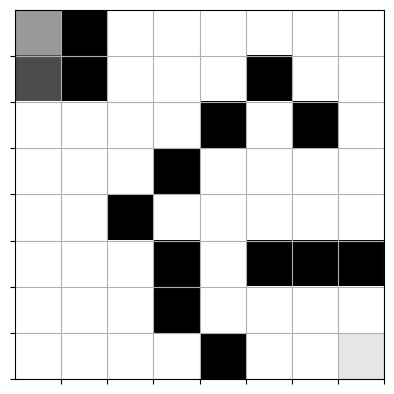

In [92]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [93]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [94]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [95]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# Q-Training Algorithm Code Block

This is my deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward.

We will be tweaking different arguments to experimentally find a configuration that either takes the least time or least epochs

In [96]:
def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon 

    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    

    
    #Game loop
    for epoch in range(n_epoch):
        #randomly select a free cell
        agent_cell = np.random.randint(0, high=7, size=2)
        #reset the maze with agent set to above position
        qmaze.reset([0,0])
        #redraws maze
        envstate = qmaze.observe()
        loss = 0
        n_episodes = 0
        
        #game loops until end condition is met
        while qmaze.game_status() == 'not_over':
            #instance replay is recorded
            previous_envstate = envstate
            
            #current valid actions are fetched (map boundaries are disallowed)
            valid_actions = qmaze.valid_actions()
            
            #random action vs learned action ratio defined by epsilon
            
            #if the action is under epsilon, explore randomly within valid actions
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                #action of max value chosen from previous experience
                action = np.argmax(experience.predict(envstate))
            
            #game vars updated by action taken
            envstate, reward, game_status = qmaze.act(action)
            
            #episodes increment
            n_episodes += 1
            #episode logs game information in list format
            episode = [previous_envstate, action, reward, envstate, game_status]
            #save episode for experience replay
            experience.remember(episode)
            
            #fetch data to train model
            inputs, targets = experience.get_data()
            
            #updates model
            history = model.fit(inputs, targets, epochs=4, batch_size=16, verbose = 0)
            loss = model.evaluate(inputs, targets)
            
            
            #handle end conditions for win rate calculation
            
            #if game status is win
            if game_status == 'win':
                #append 1 for win
                win_history.append(1)
                #calculate win rate
                win_rate = sum(win_history)/len(win_history)
                #episode is over
   
            if game_status == 'lose':
                #append 0 for loss
                win_history.append(0)
                #calculate win rate
                win_rate = sum(win_history)/len(win_history)
                #episode is over
        


    #Print the epoch, loss, episodes, win count, and win rate for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        
        # We simply check if training has exhausted all free cells and if in all
        # cases the agent won.
        if win_rate > 0.9 : epsilon = 0.05
            
        #Checks if last ~32 runs are all wins to determine finishing win rate
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break
    
    
    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

## Running the model

The output shows the completion status of our current model.

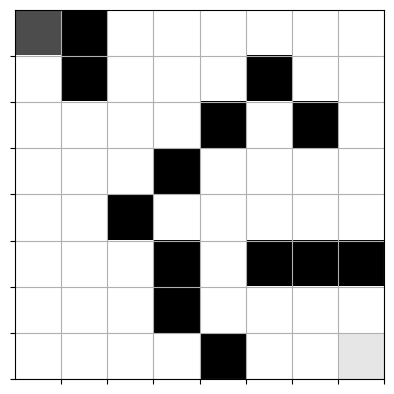

In [97]:
qmaze = TreasureMaze(maze)
show(qmaze)

The next block is the implementation of our learning model

In [98]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

10/10 [==============================] - 0s 100us/step
Epoch: 000/14999 | Loss: 0.0006 | Episodes: 140 | Win count: 0 | Win rate: 0.000 | time: 3.4 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 95us/step
Epoch: 001/14999 | Loss: 0.0009 | Episodes: 140 | Win count: 0 | Win rate: 0.000 | time: 6.3 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step
Epoch: 002/14999 | Loss: 0.0002 | Episodes: 149 | Win count: 0 | Win rate: 0.000 | time: 8.4 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 003/14999 | Loss: 0.0018 | Episodes: 147 | Win count: 0 | Win rate: 0.000 | time: 10.7 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 004/14999 | Loss: 0.0001 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 12.9 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 005/14999 | Loss: 0.0009 | Episodes: 95 | Win count: 1 | Win rate: 0.167 | time: 14.5 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 006/14999 | Loss: 0.0004 | Episodes: 93 | Win count: 2 | Win rate: 0.286 | time: 15.9 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 007/14999 | Loss: 0.0006 | Episodes: 52 | Win count: 3 | Win rate: 0.375 | time: 16.7 seconds
10/10 [==============================] - 0s 150us/step


10/10 [==============================] - 0s 100us/step
Epoch: 008/14999 | Loss: 0.0018 | Episodes: 116 | Win count: 4 | Win rate: 0.444 | time: 18.4 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 009/14999 | Loss: 0.0005 | Episodes: 72 | Win count: 5 | Win rate: 0.500 | time: 19.7 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 010/14999 | Loss: 0.0015 | Episodes: 63 | Win count: 6 | Win rate: 0.545 | time: 21.3 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 011/14999 | Loss: 0.0014 | Episodes: 83 | Win count: 7 | Win rate: 0.583 | time: 22.6 seconds
10/10 [==============================] - 0s 101us/step
Epoch: 012/14999 | Loss: 0.0025 | Episodes: 37 | Win count: 8 | Win rate: 0.615 | time: 23.2 seconds
10/10 [==============================] - 0s 127us/step


10/10 [==============================] - 0s 0us/step
Epoch: 013/14999 | Loss: 0.0014 | Episodes: 102 | Win count: 9 | Win rate: 0.643 | time: 24.7 seconds
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 102us/step
Epoch: 014/14999 | Loss: 0.0005 | Episodes: 63 | Win count: 10 | Win rate: 0.667 | time: 25.6 seconds
10/10 [==============================] - 0s 101us/step
Epoch: 015/14999 | Loss: 0.0022 | Episodes: 49 | Win count: 11 | Win rate: 0.688 | time: 26.3 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 016/14999 | Loss: 0.0002 | Episodes: 52 | Win count: 12 | Win rate: 0.706 | time: 27.1 seconds
10/10 [==============================] - 0s 0us/step


Epoch: 017/14999 | Loss: 0.0006 | Episodes: 38 | Win count: 13 | Win rate: 0.722 | time: 27.6 seconds
10/10 [==============================] - 0s 152us/step
Epoch: 018/14999 | Loss: 0.0006 | Episodes: 30 | Win count: 14 | Win rate: 0.737 | time: 28.1 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 019/14999 | Loss: 0.0015 | Episodes: 41 | Win count: 15 | Win rate: 0.750 | time: 28.7 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 020/14999 | Loss: 0.0012 | Episodes: 24 | Win count: 16 | Win rate: 0.762 | time: 29.1 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 021/14999 | Loss: 0.0010 | Episodes: 30 | Win count: 17 | Win rate: 0.773 | time: 29.6 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 022/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 18 | Win rate: 0.783 | time: 30.0 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 023/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 19 | Win rate: 0.792 | time: 30.4 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 024/14999 | Loss: 0.0019 | Episodes: 24 | Win count: 20 | Win rate: 0.800 | time: 30.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 025/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 21 | Win rate: 0.808 | time: 31.2 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 026/14999 | Loss: 0.0003 | Episodes: 37 | Win count: 22 | Win rate: 0.815 | time: 31.8 seconds
10/10 [==============================] - 0s 104us/step


10/10 [==============================] - 0s 100us/step
Epoch: 027/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 23 | Win rate: 0.821 | time: 32.2 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 028/14999 | Loss: 0.0010 | Episodes: 44 | Win count: 24 | Win rate: 0.828 | time: 32.9 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 029/14999 | Loss: 0.0008 | Episodes: 31 | Win count: 25 | Win rate: 0.833 | time: 33.4 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 030/14999 | Loss: 0.0006 | Episodes: 27 | Win count: 26 | Win rate: 0.839 | time: 33.9 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 031/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 27 | Win rate: 0.844 | time: 34.3 seconds
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 100us/step
Epoch: 032/14999 | Loss: 0.0003 | Episodes: 41 | Win count: 28 | Win rate: 0.848 | time: 34.9 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 51us/step
Epoch: 033/14999 | Loss: 0.0011 | Episodes: 141 | Win count: 28 | Win rate: 0.824 | time: 37.9 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 034/14999 | Loss: 0.0005 | Episodes: 139 | Win count: 28 | Win rate: 0.800 | time: 40.1 seconds
10/10 [==============================] - 0s 154us/step
Epoch: 035/14999 | Loss: 0.0010 | Episodes: 24 | Win count: 29 | Win rate: 0.806 | time: 40.4 seconds
10/10 [==============================] - 0s 108us/step
Epoch: 036/14999 | Loss: 0.0017 | Episodes: 30 | Win count: 30 | Win rate: 0.811 | time: 40.9 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 037/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 31 | Win rate: 0.816 | time: 41.4 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 038/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 32 | Win rate: 0.821 | time: 41.7 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 039/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 33 | Win rate: 0.825 | time: 42.2 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 040/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 34 | Win rate: 0.829 | time: 42.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 041/14999 | Loss: 0.0008 | Episodes: 34 | Win count: 35 | Win rate: 0.833 | time: 43.1 seconds
10/10 [==============================] - 0s 103us/step
Epoch: 042/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 36 | Win rate: 0.837 | time: 43.7 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 043/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 37 | Win rate: 0.841 | time: 44.2 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step
Epoch: 044/14999 | Loss: 0.0018 | Episodes: 29 | Win count: 38 | Win rate: 0.844 | time: 44.6 seconds
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 0us/step
Epoch: 045/14999 | Loss: 0.0003 | Episodes: 144 | Win count: 39 | Win rate: 0.848 | time: 47.0 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 046/14999 | Loss: 0.0006 | Episodes: 30 | Win count: 40 | Win rate: 0.851 | time: 47.5 seconds
10/10 [==============================] - 0s 101us/step
Epoch: 047/14999 | Loss: 0.0009 | Episodes: 36 | Win count: 41 | Win rate: 0.854 | time: 48.1 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 048/14999 | Loss: 0.0001 | Episodes: 47 | Win count: 42 | Win rate: 0.857 | time: 49.0 seconds
10/10 [==============================] - 0s 980us/step


10/10 [==============================] - 0s 100us/step
Epoch: 049/14999 | Loss: 0.0008 | Episodes: 44 | Win count: 43 | Win rate: 0.860 | time: 50.1 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 050/14999 | Loss: 0.0012 | Episodes: 40 | Win count: 44 | Win rate: 0.863 | time: 50.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 051/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 45 | Win rate: 0.865 | time: 51.1 seconds
10/10 [==============================] - 0s 203us/step
Epoch: 052/14999 | Loss: 0.0005 | Episodes: 30 | Win count: 46 | Win rate: 0.868 | time: 51.5 seconds
10/10 [==============================] - 0s 50us/step


10/10 [==============================] - 0s 0us/step
Epoch: 053/14999 | Loss: 0.0003 | Episodes: 35 | Win count: 47 | Win rate: 0.870 | time: 52.2 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 054/14999 | Loss: 0.0010 | Episodes: 38 | Win count: 48 | Win rate: 0.873 | time: 52.9 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 055/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 49 | Win rate: 0.875 | time: 53.5 seconds
10/10 [==============================] - 0s 101us/step
Epoch: 056/14999 | Loss: 0.0002 | Episodes: 31 | Win count: 50 | Win rate: 0.877 | time: 54.0 seconds
10/10 [==============================] - 0s 103us/step


10/10 [==============================] - 0s 104us/step
Epoch: 057/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 51 | Win rate: 0.879 | time: 54.4 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 058/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 52 | Win rate: 0.881 | time: 54.8 seconds
10/10 [==============================] - 0s 101us/step
Epoch: 059/14999 | Loss: 0.0008 | Episodes: 38 | Win count: 53 | Win rate: 0.883 | time: 55.4 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 060/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 54 | Win rate: 0.885 | time: 55.7 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 061/14999 | Loss: 0.0018 | Episodes: 26 | Win count: 55 | Win rate: 0.887 | time: 56.1 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 062/14999 | Loss: 0.0006 | Episodes: 37 | Win count: 56 | Win rate: 0.889 | time: 56.6 seconds
10/10 [==============================] - 0s 99us/step
Epoch: 063/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 57 | Win rate: 0.891 | time: 57.0 seconds
10/10 [==============================] - 0s 107us/step
Epoch: 064/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 58 | Win rate: 0.892 | time: 57.4 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 065/14999 | Loss: 0.0017 | Episodes: 26 | Win count: 59 | Win rate: 0.894 | time: 57.8 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 30us/step
Epoch: 066/14999 | Loss: 0.0014 | Episodes: 139 | Win count: 59 | Win rate: 0.881 | time: 59.8 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 067/14999 | Loss: 0.0014 | Episodes: 28 | Win count: 60 | Win rate: 0.882 | time: 60.2 seconds
10/10 [==============================] - 0s 110us/step


10/10 [==============================] - 0s 102us/step
Epoch: 068/14999 | Loss: 0.0030 | Episodes: 32 | Win count: 61 | Win rate: 0.884 | time: 60.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 069/14999 | Loss: 0.0012 | Episodes: 32 | Win count: 62 | Win rate: 0.886 | time: 61.0 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 070/14999 | Loss: 0.0005 | Episodes: 28 | Win count: 63 | Win rate: 0.887 | time: 61.4 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 071/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 64 | Win rate: 0.889 | time: 61.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 072/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 65 | Win rate: 0.890 | time: 62.2 seconds
10/10 [==============================] - 0s 50us/step


10/10 [==============================] - 0s 102us/step
Epoch: 073/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 66 | Win rate: 0.892 | time: 62.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 074/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 67 | Win rate: 0.893 | time: 63.3 seconds
10/10 [==============================] - 0s 99us/step
Epoch: 075/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 68 | Win rate: 0.895 | time: 63.7 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 076/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 69 | Win rate: 0.896 | time: 64.2 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 077/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 70 | Win rate: 0.897 | time: 64.6 seconds
10/10 [==============================] - 0s 98us/step
Epoch: 078/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 71 | Win rate: 0.899 | time: 65.0 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 102us/step
Epoch: 079/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 72 | Win rate: 0.900 | time: 65.4 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 080/14999 | Loss: 0.0005 | Episodes: 30 | Win count: 73 | Win rate: 0.901 | time: 65.8 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 102us/step
Epoch: 081/14999 | Loss: 0.0008 | Episodes: 139 | Win count: 73 | Win rate: 0.890 | time: 67.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 082/14999 | Loss: 0.0008 | Episodes: 34 | Win count: 74 | Win rate: 0.892 | time: 68.4 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 251us/step
Epoch: 083/14999 | Loss: 0.0006 | Episodes: 140 | Win count: 74 | Win rate: 0.881 | time: 70.7 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step
Epoch: 084/14999 | Loss: 0.0014 | Episodes: 140 | Win count: 74 | Win rate: 0.871 | time: 72.5 seconds
10/10 [==============================] - 0s 103us/step


10/10 [==============================] - 0s 0us/step
Epoch: 085/14999 | Loss: 0.0006 | Episodes: 140 | Win count: 74 | Win rate: 0.860 | time: 74.4 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 086/14999 | Loss: 0.0002 | Episodes: 154 | Win count: 75 | Win rate: 0.862 | time: 76.9 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 98us/step
Epoch: 087/14999 | Loss: 0.0004 | Episodes: 114 | Win count: 76 | Win rate: 0.864 | time: 78.5 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 088/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 77 | Win rate: 0.865 | time: 78.9 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 089/14999 | Loss: 0.0008 | Episodes: 30 | Win count: 78 | Win rate: 0.867 | time: 79.3 seconds
10/10 [==============================] - 0s 103us/step
Epoch: 090/14999 | Loss: 0.0013 | Episodes: 34 | Win count: 79 | Win rate: 0.868 | time: 79.8 seconds
10/10 [==============================] - 0s 104us/step
Epoch: 091/14999 | Loss: 0.0002 | Episodes: 32 | Win count: 80 | Win rate: 0.870 | time: 80.4 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 092/14999 | Loss: 0.0004 | Episodes: 34 | Win count: 81 | Win rate: 0.871 | time: 80.9 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 093/14999 | Loss: 0.0010 | Episodes: 30 | Win count: 82 | Win rate: 0.872 | time: 81.3 seconds
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 100us/step
Epoch: 094/14999 | Loss: 0.0002 | Episodes: 115 | Win count: 83 | Win rate: 0.874 | time: 82.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 095/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 84 | Win rate: 0.875 | time: 83.2 seconds
10/10 [==============================] - 0s 97us/step
Epoch: 096/14999 | Loss: 0.0021 | Episodes: 28 | Win count: 85 | Win rate: 0.876 | time: 83.6 seconds
10/10 [==============================] - 0s 139us/step
Epoch: 097/14999 | Loss: 0.0014 | Episodes: 28 | Win count: 86 | Win rate: 0.878 | time: 84.1 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 098/14999 | Loss: 0.0005 | Episodes: 30 | Win count: 87 | Win rate: 0.879 | time: 84.6 seconds
10/10 [==============================] - 0s 200us/step


10/10 [==============================] - 0s 105us/step
Epoch: 099/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 88 | Win rate: 0.880 | time: 85.2 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 100/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 89 | Win rate: 0.881 | time: 85.8 seconds
10/10 [==============================] - 0s 103us/step
Epoch: 101/14999 | Loss: 0.0009 | Episodes: 28 | Win count: 90 | Win rate: 0.882 | time: 86.2 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 102/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 91 | Win rate: 0.883 | time: 86.5 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 103/14999 | Loss: 0.0013 | Episodes: 29 | Win count: 92 | Win rate: 0.885 | time: 86.9 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 102us/step
Epoch: 104/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 93 | Win rate: 0.886 | time: 87.2 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 105/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 94 | Win rate: 0.887 | time: 87.5 seconds
10/10 [==============================] - 0s 94us/step
Epoch: 106/14999 | Loss: 0.0010 | Episodes: 26 | Win count: 95 | Win rate: 0.888 | time: 87.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 107/14999 | Loss: 0.0011 | Episodes: 68 | Win count: 96 | Win rate: 0.889 | time: 88.7 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 124us/step
Epoch: 108/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 97 | Win rate: 0.890 | time: 89.0 seconds
10/10 [==============================] - 0s 99us/step
Epoch: 109/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 98 | Win rate: 0.891 | time: 89.4 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 110/14999 | Loss: 0.0005 | Episodes: 34 | Win count: 99 | Win rate: 0.892 | time: 89.8 seconds
10/10 [==============================] - 0s 151us/step
Epoch: 111/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 100 | Win rate: 0.893 | time: 90.2 seconds
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 105us/step
Epoch: 112/14999 | Loss: 0.0006 | Episodes: 38 | Win count: 101 | Win rate: 0.894 | time: 90.7 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 113/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 102 | Win rate: 0.895 | time: 91.0 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 114/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 103 | Win rate: 0.896 | time: 91.7 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 115/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 104 | Win rate: 0.897 | time: 92.1 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 116/14999 | Loss: 0.0001 | Episodes: 33 | Win count: 105 | Win rate: 0.897 | time: 92.5 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 117/14999 | Loss: 0.0012 | Episodes: 26 | Win count: 106 | Win rate: 0.898 | time: 92.8 seconds


10/10 [==============================] - 0s 0us/step
Epoch: 118/14999 | Loss: 0.0001 | Episodes: 43 | Win count: 107 | Win rate: 0.899 | time: 93.4 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 119/14999 | Loss: 0.0002 | Episodes: 27 | Win count: 108 | Win rate: 0.900 | time: 93.9 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 120/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 109 | Win rate: 0.901 | time: 94.2 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 121/14999 | Loss: 0.0005 | Episodes: 29 | Win count: 110 | Win rate: 0.902 | time: 94.6 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 122/14999 | Loss: 0.0015 | Episodes: 50 | Win count: 111 | Win rate: 0.902 | time: 95.3 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 123/14999 | Loss: 0.0003 | Episodes: 39 | Win count: 112 | Win rate: 0.903 | time: 95.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 124/14999 | Loss: 0.0014 | Episodes: 26 | Win count: 113 | Win rate: 0.904 | time: 96.3 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 125/14999 | Loss: 0.0002 | Episodes: 32 | Win count: 114 | Win rate: 0.905 | time: 96.8 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 126/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 115 | Win rate: 0.906 | time: 97.4 seconds
10/10 [==============================] - 0s 51us/step
Epoch: 127/14999 | Loss: 0.0007 | Episodes: 31 | Win count: 116 | Win rate: 0.906 | time: 98.0 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 128/14999 | Loss: 0.0003 | Episodes: 32 | Win count: 117 | Win rate: 0.907 | time: 98.5 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 129/14999 | Loss: 0.0015 | Episodes: 28 | Win count: 118 | Win rate: 0.908 | time: 99.1 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 130/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 119 | Win rate: 0.908 | time: 99.6 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 131/14999 | Loss: 0.0010 | Episodes: 24 | Win count: 120 | Win rate: 0.909 | time: 100.3 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 132/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 121 | Win rate: 0.910 | time: 100.8 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 133/14999 | Loss: 0.0009 | Episodes: 33 | Win count: 122 | Win rate: 0.910 | time: 101.4 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 134/14999 | Loss: 0.0002 | Episodes: 34 | Win count: 123 | Win rate: 0.911 | time: 102.0 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 135/14999 | Loss: 0.0009 | Episodes: 36 | Win count: 124 | Win rate: 0.912 | time: 102.5 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 136/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 125 | Win rate: 0.912 | time: 103.0 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 137/14999 | Loss: 0.0002 | Episodes: 48 | Win count: 126 | Win rate: 0.913 | time: 103.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 138/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 127 | Win rate: 0.914 | time: 104.5 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 139/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 128 | Win rate: 0.914 | time: 105.1 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 140/14999 | Loss: 0.0012 | Episodes: 27 | Win count: 129 | Win rate: 0.915 | time: 105.6 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 141/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 130 | Win rate: 0.915 | time: 105.9 seconds
10/10 [==============================] - 0s 150us/step
Epoch: 142/14999 | Loss: 0.0016 | Episodes: 28 | Win count: 131 | Win rate: 0.916 | time: 106.4 seconds
10/10 [==============================] - 0s 61us/step
Epoch: 143/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 132 | Win rate: 0.917 | time: 106.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 144/14999 | Loss: 0.0003 | Episodes: 40 | Win count: 133 | Win rate: 0.917 | time: 107.3 seconds
10/10 [==============================] - 0s 97us/step


10/10 [==============================] - 0s 99us/step
Epoch: 145/14999 | Loss: 0.0007 | Episodes: 24 | Win count: 134 | Win rate: 0.918 | time: 107.8 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 146/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 135 | Win rate: 0.918 | time: 108.1 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 147/14999 | Loss: 0.0005 | Episodes: 30 | Win count: 136 | Win rate: 0.919 | time: 108.7 seconds
10/10 [==============================] - 0s 99us/step
Epoch: 148/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 137 | Win rate: 0.919 | time: 109.2 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 149/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 138 | Win rate: 0.920 | time: 109.5 seconds
10/10 [==============================] - 0s 51us/step
Epoch: 150/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 139 | Win rate: 0.921 | time: 109.9 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 151/14999 | Loss: 0.0007 | Episodes: 28 | Win count: 140 | Win rate: 0.921 | time: 110.4 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 152/14999 | Loss: 0.0005 | Episodes: 36 | Win count: 141 | Win rate: 0.922 | time: 111.0 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 153/14999 | Loss: 0.0004 | Episodes: 33 | Win count: 142 | Win rate: 0.922 | time: 111.5 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 154/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 143 | Win rate: 0.923 | time: 112.0 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 155/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 144 | Win rate: 0.923 | time: 112.4 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 156/14999 | Loss: 0.0002 | Episodes: 29 | Win count: 145 | Win rate: 0.924 | time: 112.8 seconds
10/10 [==============================] - 0s 98us/step
Epoch: 157/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 146 | Win rate: 0.924 | time: 113.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 158/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 147 | Win rate: 0.925 | time: 114.2 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 159/14999 | Loss: 0.0003 | Episodes: 34 | Win count: 148 | Win rate: 0.925 | time: 114.7 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 101us/step
Epoch: 160/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 149 | Win rate: 0.925 | time: 115.2 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 161/14999 | Loss: 0.0013 | Episodes: 32 | Win count: 150 | Win rate: 0.926 | time: 116.0 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 162/14999 | Loss: 0.0010 | Episodes: 24 | Win count: 151 | Win rate: 0.926 | time: 117.0 seconds
10/10 [==============================] - 0s 101us/step
Epoch: 163/14999 | Loss: 0.0002 | Episodes: 39 | Win count: 152 | Win rate: 0.927 | time: 118.0 seconds
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 151us/step
Epoch: 164/14999 | Loss: 0.0003 | Episodes: 36 | Win count: 153 | Win rate: 0.927 | time: 118.9 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 165/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 154 | Win rate: 0.928 | time: 119.4 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 166/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 155 | Win rate: 0.928 | time: 119.8 seconds
10/10 [==============================] - 0s 108us/step
Epoch: 167/14999 | Loss: 0.0009 | Episodes: 38 | Win count: 156 | Win rate: 0.929 | time: 120.5 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 168/14999 | Loss: 0.0010 | Episodes: 34 | Win count: 157 | Win rate: 0.929 | time: 121.1 seconds
10/10 [==============================] - 0s 94us/step


10/10 [==============================] - 0s 100us/step
Epoch: 169/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 158 | Win rate: 0.929 | time: 121.6 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 170/14999 | Loss: 0.0003 | Episodes: 27 | Win count: 159 | Win rate: 0.930 | time: 122.2 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 171/14999 | Loss: 0.0005 | Episodes: 28 | Win count: 160 | Win rate: 0.930 | time: 122.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 172/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 161 | Win rate: 0.931 | time: 123.3 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 173/14999 | Loss: 0.0009 | Episodes: 34 | Win count: 162 | Win rate: 0.931 | time: 124.1 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 302us/step
Epoch: 174/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 163 | Win rate: 0.931 | time: 124.6 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 175/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 164 | Win rate: 0.932 | time: 125.2 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 176/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 165 | Win rate: 0.932 | time: 125.7 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 177/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 166 | Win rate: 0.933 | time: 126.4 seconds
10/10 [==============================] - 0s 205us/step
Epoch: 178/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 167 | Win rate: 0.933 | time: 127.1 seconds
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 100us/step
Epoch: 179/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 168 | Win rate: 0.933 | time: 127.7 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 180/14999 | Loss: 0.0012 | Episodes: 30 | Win count: 169 | Win rate: 0.934 | time: 128.1 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 181/14999 | Loss: 0.0016 | Episodes: 34 | Win count: 170 | Win rate: 0.934 | time: 128.7 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 182/14999 | Loss: 0.0008 | Episodes: 61 | Win count: 171 | Win rate: 0.934 | time: 129.5 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 183/14999 | Loss: 0.0013 | Episodes: 60 | Win count: 172 | Win rate: 0.935 | time: 130.3 seconds
10/10 [==============================] - 0s 151us/step
Epoch: 184/14999 | Loss: 0.0007 | Episodes: 32 | Win count: 173 | Win rate: 0.935 | time: 130.8 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 185/14999 | Loss: 0.0013 | Episodes: 35 | Win count: 174 | Win rate: 0.935 | time: 131.3 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 186/14999 | Loss: 0.0011 | Episodes: 41 | Win count: 175 | Win rate: 0.936 | time: 132.0 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 187/14999 | Loss: 0.0024 | Episodes: 27 | Win count: 176 | Win rate: 0.936 | time: 132.5 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 188/14999 | Loss: 0.0003 | Episodes: 27 | Win count: 177 | Win rate: 0.937 | time: 133.0 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 189/14999 | Loss: 0.0010 | Episodes: 36 | Win count: 178 | Win rate: 0.937 | time: 133.8 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 190/14999 | Loss: 0.0013 | Episodes: 26 | Win count: 179 | Win rate: 0.937 | time: 134.4 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 191/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 180 | Win rate: 0.938 | time: 135.3 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 192/14999 | Loss: 0.0012 | Episodes: 24 | Win count: 181 | Win rate: 0.938 | time: 135.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 193/14999 | Loss: 0.0006 | Episodes: 24 | Win count: 182 | Win rate: 0.938 | time: 136.2 seconds
10/10 [==============================] - 0s 101us/step
Epoch: 194/14999 | Loss: 0.0015 | Episodes: 26 | Win count: 183 | Win rate: 0.938 | time: 136.7 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 195/14999 | Loss: 0.0007 | Episodes: 28 | Win count: 184 | Win rate: 0.939 | time: 137.2 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 196/14999 | Loss: 0.0011 | Episodes: 38 | Win count: 185 | Win rate: 0.939 | time: 137.7 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 197/14999 | Loss: 0.0002 | Episodes: 31 | Win count: 186 | Win rate: 0.939 | time: 138.2 seconds
10/10 [==============================] - 0s 98us/step
Epoch: 198/14999 | Loss: 0.0000 | Episodes: 60 | Win count: 187 | Win rate: 0.940 | time: 139.4 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 199/14999 | Loss: 0.0007 | Episodes: 24 | Win count: 188 | Win rate: 0.940 | time: 140.0 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 101us/step
Epoch: 200/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 189 | Win rate: 0.940 | time: 140.3 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 201/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 190 | Win rate: 0.941 | time: 140.9 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 202/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 191 | Win rate: 0.941 | time: 141.5 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 203/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 192 | Win rate: 0.941 | time: 142.0 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 204/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 193 | Win rate: 0.941 | time: 142.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 205/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 194 | Win rate: 0.942 | time: 143.2 seconds
10/10 [==============================] - 0s 0us/st

10/10 [==============================] - 0s 102us/step
Epoch: 206/14999 | Loss: 0.0004 | Episodes: 28 | Win count: 195 | Win rate: 0.942 | time: 143.7 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 207/14999 | Loss: 0.0019 | Episodes: 34 | Win count: 196 | Win rate: 0.942 | time: 144.3 seconds
10/10 [==============================] - 0s 107us/step
Epoch: 208/14999 | Loss: 0.0002 | Episodes: 42 | Win count: 197 | Win rate: 0.943 | time: 145.1 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 209/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 198 | Win rate: 0.943 | time: 145.7 seconds
10/10 [==============================] - 0s 200us/step


10/10 [==============================] - 0s 100us/step
Epoch: 210/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 199 | Win rate: 0.943 | time: 146.2 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 211/14999 | Loss: 0.0002 | Episodes: 38 | Win count: 200 | Win rate: 0.943 | time: 146.9 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 212/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 201 | Win rate: 0.944 | time: 147.6 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 213/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 202 | Win rate: 0.944 | time: 148.3 seconds
10/10 [==============================] - 0s 0us/step


Epoch: 214/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 203 | Win rate: 0.944 | time: 149.0 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 215/14999 | Loss: 0.0006 | Episodes: 27 | Win count: 204 | Win rate: 0.944 | time: 149.7 seconds
10/10 [==============================] - 0s 102us/step
Epoch: 216/14999 | Loss: 0.0002 | Episodes: 34 | Win count: 205 | Win rate: 0.945 | time: 150.5 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 217/14999 | Loss: 0.0012 | Episodes: 24 | Win count: 206 | Win rate: 0.945 | time: 151.0 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 218/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 207 | Win rate: 0.945 | time: 151.5 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 219/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 208 | Win rate: 0.945 | time: 152.0 seconds
10/10 [==============================] - 0s 104us/step


10/10 [==============================] - 0s 904us/step
Epoch: 220/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 209 | Win rate: 0.946 | time: 152.9 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 221/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 210 | Win rate: 0.946 | time: 153.5 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 222/14999 | Loss: 0.0000 | Episodes: 27 | Win count: 211 | Win rate: 0.946 | time: 153.9 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 223/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 212 | Win rate: 0.946 | time: 154.6 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 224/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 213 | Win rate: 0.947 | time: 155.1 seconds
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 100us/step
Epoch: 225/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 214 | Win rate: 0.947 | time: 155.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 226/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 215 | Win rate: 0.947 | time: 156.1 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 227/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 216 | Win rate: 0.947 | time: 156.8 seconds
10/10 [==============================] - 0s 103us/step
Epoch: 228/14999 | Loss: 0.0001 | Episodes: 35 | Win count: 217 | Win rate: 0.948 | time: 157.4 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 229/14999 | Loss: 0.0011 | Episodes: 28 | Win count: 218 | Win rate: 0.948 | time: 157.9 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 230/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 219 | Win rate: 0.948 | time: 158.5 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 231/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 220 | Win rate: 0.948 | time: 158.9 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 232/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 221 | Win rate: 0.948 | time: 159.5 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 233/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 222 | Win rate: 0.949 | time: 160.0 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 234/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 223 | Win rate: 0.949 | time: 160.5 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 235/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 224 | Win rate: 0.949 | time: 161.0 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 236/14999 | Loss: 0.0010 | Episodes: 35 | Win count: 225 | Win rate: 0.949 | time: 161.6 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 237/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 226 | Win rate: 0.950 | time: 162.1 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 238/14999 | Loss: 0.0009 | Episodes: 30 | Win count: 227 | Win rate: 0.950 | time: 162.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 239/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 228 | Win rate: 0.950 | time: 163.0 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 151us/step
Epoch: 240/14999 | Loss: 0.0011 | Episodes: 26 | Win count: 229 | Win rate: 0.950 | time: 163.5 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 241/14999 | Loss: 0.0002 | Episodes: 34 | Win count: 230 | Win rate: 0.950 | time: 164.1 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 242/14999 | Loss: 0.0002 | Episodes: 34 | Win count: 231 | Win rate: 0.951 | time: 164.8 seconds
10/10 [==============================] - 0s 151us/step
Epoch: 243/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 232 | Win rate: 0.951 | time: 165.3 seconds
10/10 [==============================] - 0s 102us/step
Epoch: 244/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 233 | Win rate: 0.951 | time: 165.9 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 31us/step
Epoch: 245/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 234 | Win rate: 0.951 | time: 166.4 seconds
10/10 [==============================] - 0s 101us/step
Epoch: 246/14999 | Loss: 0.0003 | Episodes: 39 | Win count: 235 | Win rate: 0.951 | time: 167.2 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 247/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 236 | Win rate: 0.952 | time: 167.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 248/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 237 | Win rate: 0.952 | time: 168.2 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 249/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 238 | Win rate: 0.952 | time: 168.7 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 250/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 239 | Win rate: 0.952 | time: 169.3 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 251/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 240 | Win rate: 0.952 | time: 170.3 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 252/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 241 | Win rate: 0.953 | time: 170.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 253/14999 | Loss: 0.0000 | Episodes: 29 | Win count: 242 | Win rate: 0.953 | time: 171.3 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 254/14999 | Loss: 0.0007 | Episodes: 34 | Win count: 243 | Win rate: 0.953 | time: 171.9 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 255/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 244 | Win rate: 0.953 | time: 172.4 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 256/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 245 | Win rate: 0.953 | time: 172.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 257/14999 | Loss: 0.0008 | Episodes: 36 | Win count: 246 | Win rate: 0.953 | time: 173.5 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 258/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 247 | Win rate: 0.954 | time: 173.8 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 259/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 248 | Win rate: 0.954 | time: 174.4 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 260/14999 | Loss: 0.0004 | Episodes: 44 | Win count: 249 | Win rate: 0.954 | time: 175.0 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 261/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 250 | Win rate: 0.954 | time: 175.7 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 262/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 251 | Win rate: 0.954 | time: 176.2 seconds
10/10 [==============================] - 0s 151us/step


10/10 [==============================] - 0s 0us/step
Epoch: 263/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 252 | Win rate: 0.955 | time: 176.7 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 264/14999 | Loss: 0.0010 | Episodes: 28 | Win count: 253 | Win rate: 0.955 | time: 177.2 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 265/14999 | Loss: 0.0007 | Episodes: 38 | Win count: 254 | Win rate: 0.955 | time: 177.8 seconds
10/10 [==============================] - 0s 101us/step
Epoch: 266/14999 | Loss: 0.0008 | Episodes: 39 | Win count: 255 | Win rate: 0.955 | time: 178.5 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 267/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 256 | Win rate: 0.955 | time: 178.8 seconds
10/10 [==============================] - 0s 97us/step


10/10 [==============================] - 0s 101us/step
Epoch: 268/14999 | Loss: 0.0010 | Episodes: 34 | Win count: 257 | Win rate: 0.955 | time: 179.3 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 269/14999 | Loss: 0.0009 | Episodes: 38 | Win count: 258 | Win rate: 0.956 | time: 180.0 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 270/14999 | Loss: 0.0012 | Episodes: 26 | Win count: 259 | Win rate: 0.956 | time: 180.5 seconds
10/10 [==============================] - 0s 301us/step
Epoch: 271/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 260 | Win rate: 0.956 | time: 181.1 seconds
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 51us/step
Epoch: 272/14999 | Loss: 0.0011 | Episodes: 30 | Win count: 261 | Win rate: 0.956 | time: 182.0 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 273/14999 | Loss: 0.0011 | Episodes: 30 | Win count: 262 | Win rate: 0.956 | time: 182.7 seconds
10/10 [==============================] - 0s 201us/step
Epoch: 274/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 263 | Win rate: 0.956 | time: 183.3 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 275/14999 | Loss: 0.0013 | Episodes: 28 | Win count: 264 | Win rate: 0.957 | time: 183.9 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 276/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 265 | Win rate: 0.957 | time: 184.4 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step
Epoch: 277/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 266 | Win rate: 0.957 | time: 184.9 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 278/14999 | Loss: 0.0015 | Episodes: 24 | Win count: 267 | Win rate: 0.957 | time: 185.4 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 279/14999 | Loss: 0.0008 | Episodes: 32 | Win count: 268 | Win rate: 0.957 | time: 186.0 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 280/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 269 | Win rate: 0.957 | time: 186.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 281/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 270 | Win rate: 0.957 | time: 187.2 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step
Epoch: 282/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 271 | Win rate: 0.958 | time: 187.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 283/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 272 | Win rate: 0.958 | time: 188.3 seconds
10/10 [==============================] - 0s 700us/step
Epoch: 284/14999 | Loss: 0.0010 | Episodes: 35 | Win count: 273 | Win rate: 0.958 | time: 189.4 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 285/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 274 | Win rate: 0.958 | time: 190.0 seconds
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 91us/step
Epoch: 286/14999 | Loss: 0.0003 | Episodes: 50 | Win count: 275 | Win rate: 0.958 | time: 191.0 seconds
10/10 [==============================] - 0s 99us/step
Epoch: 287/14999 | Loss: 0.0003 | Episodes: 42 | Win count: 276 | Win rate: 0.958 | time: 191.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 288/14999 | Loss: 0.0002 | Episodes: 42 | Win count: 277 | Win rate: 0.958 | time: 192.4 seconds
10/10 [==============================] - 0s 103us/step
Epoch: 289/14999 | Loss: 0.0003 | Episodes: 40 | Win count: 278 | Win rate: 0.959 | time: 193.1 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 290/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 279 | Win rate: 0.959 | time: 193.5 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 291/14999 | Loss: 0.0005 | Episodes: 24 | Win count: 280 | Win rate: 0.959 | time: 194.0 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 292/14999 | Loss: 0.0002 | Episodes: 31 | Win count: 281 | Win rate: 0.959 | time: 194.5 seconds
10/10 [==============================] - 0s 105us/step
Epoch: 293/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 282 | Win rate: 0.959 | time: 195.0 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 294/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 283 | Win rate: 0.959 | time: 195.9 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step
Epoch: 295/14999 | Loss: 0.0002 | Episodes: 36 | Win count: 284 | Win rate: 0.959 | time: 196.7 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 296/14999 | Loss: 0.0004 | Episodes: 36 | Win count: 285 | Win rate: 0.960 | time: 197.7 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 297/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 286 | Win rate: 0.960 | time: 198.3 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 298/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 287 | Win rate: 0.960 | time: 198.8 seconds
10/10 [==============================] - 0s 129us/step
Epoch: 299/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 288 | Win rate: 0.960 | time: 199.3 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 101us/step
Epoch: 300/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 289 | Win rate: 0.960 | time: 199.8 seconds
10/10 [==============================] - 0s 129us/step
Epoch: 301/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 290 | Win rate: 0.960 | time: 200.3 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 302/14999 | Loss: 0.0002 | Episodes: 36 | Win count: 291 | Win rate: 0.960 | time: 201.0 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 303/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 292 | Win rate: 0.961 | time: 201.6 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 304/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 293 | Win rate: 0.961 | time: 202.1 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 305/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 294 | Win rate: 0.961 | time: 202.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 306/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 295 | Win rate: 0.961 | time: 203.4 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 307/14999 | Loss: 0.0003 | Episodes: 40 | Win count: 296 | Win rate: 0.961 | time: 204.1 seconds
10/10 [==============================] - 0s 104us/step
Epoch: 308/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 297 | Win rate: 0.961 | time: 204.7 seconds


10/10 [==============================] - 0s 100us/step
Epoch: 309/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 298 | Win rate: 0.961 | time: 205.2 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 310/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 299 | Win rate: 0.961 | time: 205.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 311/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 300 | Win rate: 0.962 | time: 206.3 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 312/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 301 | Win rate: 0.962 | time: 206.7 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 313/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 302 | Win rate: 0.962 | time: 207.2 seconds
10/10 [==============================] - 0s 145us/step


10/10 [==============================] - 0s 0us/step
Epoch: 314/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 303 | Win rate: 0.962 | time: 207.6 seconds
10/10 [==============================] - 0s 200us/step
Epoch: 315/14999 | Loss: 0.0001 | Episodes: 31 | Win count: 304 | Win rate: 0.962 | time: 208.2 seconds
10/10 [==============================] - 0s 112us/step
Epoch: 316/14999 | Loss: 0.0018 | Episodes: 24 | Win count: 305 | Win rate: 0.962 | time: 208.5 seconds
10/10 [==============================] - 0s 102us/step
Epoch: 317/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 306 | Win rate: 0.962 | time: 209.1 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 318/14999 | Loss: 0.0014 | Episodes: 30 | Win count: 307 | Win rate: 0.962 | time: 209.6 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step
Epoch: 319/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 308 | Win rate: 0.963 | time: 210.1 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 320/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 309 | Win rate: 0.963 | time: 210.7 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 321/14999 | Loss: 0.0002 | Episodes: 68 | Win count: 310 | Win rate: 0.963 | time: 212.3 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 322/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 311 | Win rate: 0.963 | time: 213.2 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step
Epoch: 323/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 312 | Win rate: 0.963 | time: 214.2 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 324/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 313 | Win rate: 0.963 | time: 214.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 325/14999 | Loss: 0.0012 | Episodes: 38 | Win count: 314 | Win rate: 0.963 | time: 215.4 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 326/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 315 | Win rate: 0.963 | time: 216.0 seconds
10/10 [==============================] - 0s 107us/step


10/10 [==============================] - 0s 100us/step
Epoch: 327/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 316 | Win rate: 0.963 | time: 216.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 328/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 317 | Win rate: 0.964 | time: 217.4 seconds
10/10 [==============================] - 0s 211us/step
Epoch: 329/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 318 | Win rate: 0.964 | time: 217.9 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 330/14999 | Loss: 0.0010 | Episodes: 24 | Win count: 319 | Win rate: 0.964 | time: 218.5 seconds
10/10 [==============================] - 0s 103us/step
Epoch: 331/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 320 | Win rate: 0.964 | time: 219.3 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 332/14999 | Loss: 0.0002 | Episodes: 36 | Win count: 321 | Win rate: 0.964 | time: 219.9 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 333/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 322 | Win rate: 0.964 | time: 220.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 334/14999 | Loss: 0.0001 | Episodes: 31 | Win count: 323 | Win rate: 0.964 | time: 221.3 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 335/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 324 | Win rate: 0.964 | time: 221.8 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 336/14999 | Loss: 0.0002 | Episodes: 38 | Win count: 325 | Win rate: 0.964 | time: 222.5 seconds
10/10 [==============================] - 0s 101us/step
Epoch: 337/14999 | Loss: 0.0010 | Episodes: 45 | Win count: 326 | Win rate: 0.964 | time: 223.2 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 338/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 327 | Win rate: 0.965 | time: 223.7 seconds
10/10 [==============================] - 0s 97us/step
Epoch: 339/14999 | Loss: 0.0007 | Episodes: 24 | Win count: 328 | Win rate: 0.965 | time: 224.2 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 340/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 329 | Win rate: 0.965 | time: 225.4 seconds


10/10 [==============================] - 0s 0us/step
Epoch: 341/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 330 | Win rate: 0.965 | time: 226.0 seconds
10/10 [==============================] - 0s 250us/step
Epoch: 342/14999 | Loss: 0.0009 | Episodes: 41 | Win count: 331 | Win rate: 0.965 | time: 226.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 343/14999 | Loss: 0.0000 | Episodes: 40 | Win count: 332 | Win rate: 0.965 | time: 227.5 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 344/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 333 | Win rate: 0.965 | time: 228.2 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step
Epoch: 345/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 334 | Win rate: 0.965 | time: 228.7 seconds
10/10 [==============================] - 0s 76us/step
Epoch: 346/14999 | Loss: 0.0002 | Episodes: 31 | Win count: 335 | Win rate: 0.965 | time: 229.5 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 347/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 336 | Win rate: 0.966 | time: 230.3 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 348/14999 | Loss: 0.0002 | Episodes: 32 | Win count: 337 | Win rate: 0.966 | time: 231.0 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step
Epoch: 349/14999 | Loss: 0.0010 | Episodes: 38 | Win count: 338 | Win rate: 0.966 | time: 231.8 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 350/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 339 | Win rate: 0.966 | time: 232.5 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 351/14999 | Loss: 0.0005 | Episodes: 30 | Win count: 340 | Win rate: 0.966 | time: 233.2 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 352/14999 | Loss: 0.0010 | Episodes: 39 | Win count: 341 | Win rate: 0.966 | time: 233.8 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 353/14999 | Loss: 0.0002 | Episodes: 67 | Win count: 342 | Win rate: 0.966 | time: 234.9 seconds
10/10 [==============================] - 0s 102us/step
Epoch: 354/14999 | Loss: 0.0003 | Episodes: 41 | Win count: 343 | Win rate: 0.966 | time: 235.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 355/14999 | Loss: 0.0003 | Episodes: 38 | Win count: 344 | Win rate: 0.966 | time: 236.2 seconds
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 0us/step
Epoch: 356/14999 | Loss: 0.0003 | Episodes: 38 | Win count: 345 | Win rate: 0.966 | time: 237.0 seconds
10/10 [==============================] - 0s 101us/step
Epoch: 357/14999 | Loss: 0.0002 | Episodes: 40 | Win count: 346 | Win rate: 0.966 | time: 237.7 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 358/14999 | Loss: 0.0005 | Episodes: 24 | Win count: 347 | Win rate: 0.967 | time: 238.3 seconds
10/10 [==============================] - 0s 107us/step
Epoch: 359/14999 | Loss: 0.0015 | Episodes: 40 | Win count: 348 | Win rate: 0.967 | time: 239.0 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 360/14999 | Loss: 0.0012 | Episodes: 24 | Win count: 349 | Win rate: 0.967 | time: 239.5 seconds
10/10 [==============================] - 0s 110us/step
Epoch: 361/14999 | Loss: 0.0002 | Episodes: 44 | Win count: 350 | Win rate: 0.967 | time: 240.3 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 362/14999 | Loss: 0.0004 | Episodes: 28 | Win count: 351 | Win rate: 0.967 | time: 240.9 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 363/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 352 | Win rate: 0.967 | time: 241.3 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 364/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 353 | Win rate: 0.967 | time: 241.9 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 365/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 354 | Win rate: 0.967 | time: 242.4 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 366/14999 | Loss: 0.0012 | Episodes: 50 | Win count: 355 | Win rate: 0.967 | time: 243.2 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 367/14999 | Loss: 0.0004 | Episodes: 28 | Win count: 356 | Win rate: 0.967 | time: 243.9 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 368/14999 | Loss: 0.0020 | Episodes: 34 | Win count: 357 | Win rate: 0.967 | time: 244.8 seconds
10/10 [==============================] - 0s 150us/step


10/10 [==============================] - 0s 100us/step
Epoch: 369/14999 | Loss: 0.0011 | Episodes: 36 | Win count: 358 | Win rate: 0.968 | time: 245.8 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 370/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 359 | Win rate: 0.968 | time: 246.6 seconds
10/10 [==============================] - 0s 257us/step
Epoch: 371/14999 | Loss: 0.0002 | Episodes: 36 | Win count: 360 | Win rate: 0.968 | time: 247.3 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 372/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 361 | Win rate: 0.968 | time: 248.0 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step
Epoch: 373/14999 | Loss: 0.0004 | Episodes: 32 | Win count: 362 | Win rate: 0.968 | time: 248.7 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 374/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 363 | Win rate: 0.968 | time: 249.2 seconds
10/10 [==============================] - 0s 398us/step
Epoch: 375/14999 | Loss: 0.0011 | Episodes: 26 | Win count: 364 | Win rate: 0.968 | time: 250.0 seconds
10/10 [==============================] - 0s 104us/step
Epoch: 376/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 365 | Win rate: 0.968 | time: 250.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 377/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 366 | Win rate: 0.968 | time: 251.2 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 378/14999 | Loss: 0.0010 | Episodes: 30 | Win count: 367 | Win rate: 0.968 | time: 251.7 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 379/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 368 | Win rate: 0.968 | time: 252.5 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 380/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 369 | Win rate: 0.969 | time: 253.1 seconds
10/10 [==============================] - 0s 104us/step
Epoch: 381/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 370 | Win rate: 0.969 | time: 253.7 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 382/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 371 | Win rate: 0.969 | time: 254.2 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 383/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 372 | Win rate: 0.969 | time: 254.8 seconds
10/10 [==============================] - 0s 103us/step
Epoch: 384/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 373 | Win rate: 0.969 | time: 255.3 seconds
10/10 [==============================] - 0s 151us/step
Epoch: 385/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 374 | Win rate: 0.969 | time: 255.8 seconds
10/10 [==============================] - 0s 151us/step
Epoch: 386/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 375 | Win rate: 0.969 | time: 256.3 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 387/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 376 | Win rate: 0.969 | time: 256.8 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 388/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 377 | Win rate: 0.969 | time: 257.4 seconds
10/10 [==============================] - 0s 0us/

10/10 [==============================] - 0s 0us/step
Epoch: 389/14999 | Loss: 0.0005 | Episodes: 29 | Win count: 378 | Win rate: 0.969 | time: 258.0 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 390/14999 | Loss: 0.0001 | Episodes: 39 | Win count: 379 | Win rate: 0.969 | time: 258.7 seconds
10/10 [==============================] - 0s 151us/step
Epoch: 391/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 380 | Win rate: 0.969 | time: 259.2 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 392/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 381 | Win rate: 0.969 | time: 259.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 393/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 382 | Win rate: 0.970 | time: 260.2 seconds


10/10 [==============================] - 0s 0us/step
Epoch: 394/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 383 | Win rate: 0.970 | time: 260.9 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 395/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 384 | Win rate: 0.970 | time: 261.9 seconds
10/10 [==============================] - 0s 102us/step
Epoch: 396/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 385 | Win rate: 0.970 | time: 262.4 seconds
10/10 [==============================] - 0s 98us/step
Epoch: 397/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 386 | Win rate: 0.970 | time: 262.9 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 398/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 387 | Win rate: 0.970 | time: 263.3 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 101us/step
Epoch: 399/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 388 | Win rate: 0.970 | time: 263.8 seconds
10/10 [==============================] - 0s 98us/step
Epoch: 400/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 389 | Win rate: 0.970 | time: 265.2 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 401/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 390 | Win rate: 0.970 | time: 265.6 seconds
10/10 [==============================] - 0s 101us/step
Epoch: 402/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 391 | Win rate: 0.970 | time: 266.3 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 403/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 392 | Win rate: 0.970 | time: 267.2 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 404/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 393 | Win rate: 0.970 | time: 267.9 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 405/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 394 | Win rate: 0.970 | time: 268.4 seconds
10/10 [==============================] - 0s 102us/step
Epoch: 406/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 395 | Win rate: 0.971 | time: 268.8 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 407/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 396 | Win rate: 0.971 | time: 269.2 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 408/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 397 | Win rate: 0.971 | time: 269.7 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 409/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 398 | Win rate: 0.971 | time: 270.2 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 410/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 399 | Win rate: 0.971 | time: 270.6 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 411/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 400 | Win rate: 0.971 | time: 271.0 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 412/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 401 | Win rate: 0.971 | time: 271.4 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 413/14999 | Loss: 0.0007 | Episodes: 28 | Win count: 402 | Win rate: 0.971 | time: 271.8 seconds
10/10 [==============================] - 0s 101us/step
Epoch: 414/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 403 | Win rate: 0.971 | time: 272.2 seconds
10/10 [==============================] - 0s 155u

10/10 [==============================] - 0s 100us/step
Epoch: 415/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 404 | Win rate: 0.971 | time: 272.7 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 416/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 405 | Win rate: 0.971 | time: 273.1 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 417/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 406 | Win rate: 0.971 | time: 273.5 seconds
10/10 [==============================] - 0s 102us/step
Epoch: 418/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 407 | Win rate: 0.971 | time: 273.9 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 419/14999 | Loss: 0.0000 | Episodes: 48 | Win count: 408 | Win rate: 0.971 | time: 274.6 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 420/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 409 | Win rate: 0.971 | time: 275.0 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 421/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 410 | Win rate: 0.972 | time: 275.6 seconds
10/10 [==============================] - 0s 101us/step
Epoch: 422/14999 | Loss: 0.0010 | Episodes: 26 | Win count: 411 | Win rate: 0.972 | time: 276.2 seconds
10/10 [==============================] - 0s 98us/step
Epoch: 423/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 412 | Win rate: 0.972 | time: 276.7 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 424/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 413 | Win rate: 0.972 | time: 277.3 seconds
10/10 [==============================] - 0s 153us/step


10/10 [==============================] - 0s 0us/step
Epoch: 425/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 414 | Win rate: 0.972 | time: 277.9 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 426/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 415 | Win rate: 0.972 | time: 278.3 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 427/14999 | Loss: 0.0009 | Episodes: 28 | Win count: 416 | Win rate: 0.972 | time: 278.8 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 428/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 417 | Win rate: 0.972 | time: 279.3 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 429/14999 | Loss: 0.0009 | Episodes: 38 | Win count: 418 | Win rate: 0.972 | time: 279.9 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 99us/step
Epoch: 430/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 419 | Win rate: 0.972 | time: 280.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 431/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 420 | Win rate: 0.972 | time: 281.2 seconds
10/10 [==============================] - 0s 101us/step
Epoch: 432/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 421 | Win rate: 0.972 | time: 281.7 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 433/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 422 | Win rate: 0.972 | time: 282.2 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 434/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 423 | Win rate: 0.972 | time: 282.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 435/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 424 | Win rate: 0.972 | time: 283.0 seconds


10/10 [==============================] - 0s 151us/step
Epoch: 436/14999 | Loss: 0.0010 | Episodes: 26 | Win count: 425 | Win rate: 0.973 | time: 283.5 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 437/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 426 | Win rate: 0.973 | time: 283.9 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 438/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 427 | Win rate: 0.973 | time: 284.4 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 439/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 428 | Win rate: 0.973 | time: 284.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 440/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 429 | Win rate: 0.973 | time: 285.3 seconds
10/10 [==============================] - 0s 153us/step


10/10 [==============================] - 0s 0us/step
Epoch: 441/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 430 | Win rate: 0.973 | time: 285.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 442/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 431 | Win rate: 0.973 | time: 286.2 seconds
10/10 [==============================] - 0s 104us/step
Epoch: 443/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 432 | Win rate: 0.973 | time: 286.7 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 444/14999 | Loss: 0.0009 | Episodes: 30 | Win count: 433 | Win rate: 0.973 | time: 287.1 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 445/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 434 | Win rate: 0.973 | time: 287.6 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 97us/step
Epoch: 446/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 435 | Win rate: 0.973 | time: 288.0 seconds
10/10 [==============================] - 0s 102us/step
Epoch: 447/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 436 | Win rate: 0.973 | time: 288.4 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 448/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 437 | Win rate: 0.973 | time: 288.8 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 449/14999 | Loss: 0.0011 | Episodes: 26 | Win count: 438 | Win rate: 0.973 | time: 289.3 seconds
10/10 [==============================] - 0s 101us/step
Epoch: 450/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 439 | Win rate: 0.973 | time: 289.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 451/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 440 | Win rate: 0.973 | time: 290.2 seconds
10/10 [==============================] - 0s 0us/ste

10/10 [==============================] - 0s 0us/step
Epoch: 452/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 441 | Win rate: 0.974 | time: 290.7 seconds
10/10 [==============================] - 0s 51us/step
Epoch: 453/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 442 | Win rate: 0.974 | time: 291.1 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 454/14999 | Loss: 0.0012 | Episodes: 26 | Win count: 443 | Win rate: 0.974 | time: 291.6 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 455/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 444 | Win rate: 0.974 | time: 292.2 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 456/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 445 | Win rate: 0.974 | time: 292.8 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 457/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 446 | Win rate: 0.974 | time: 293.5 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 458/14999 | Loss: 0.0010 | Episodes: 24 | Win count: 447 | Win rate: 0.974 | time: 293.9 seconds
10/10 [==============================] - 0s 149us/step
Epoch: 459/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 448 | Win rate: 0.974 | time: 294.4 seconds
10/10 [==============================] - 0s 140us/step
Epoch: 460/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 449 | Win rate: 0.974 | time: 294.9 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 461/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 450 | Win rate: 0.974 | time: 295.3 seconds
10/10 [==============================] - 0s 136us/step
Epoch: 462/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 451 | Win rate: 0.974 | time: 295.7 seconds
10/10 [==============================] - 0s 0us/st

10/10 [==============================] - 0s 0us/step
Epoch: 463/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 452 | Win rate: 0.974 | time: 296.2 seconds
10/10 [==============================] - 0s 98us/step
Epoch: 464/14999 | Loss: 0.0009 | Episodes: 28 | Win count: 453 | Win rate: 0.974 | time: 297.3 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 465/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 454 | Win rate: 0.974 | time: 298.0 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 466/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 455 | Win rate: 0.974 | time: 298.6 seconds
10/10 [==============================] - 0s 37us/step
Epoch: 467/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 456 | Win rate: 0.974 | time: 299.1 seconds
10/10 [==============================] - 0s 0us/step


Epoch: 468/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 457 | Win rate: 0.974 | time: 299.6 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 469/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 458 | Win rate: 0.974 | time: 300.0 seconds
10/10 [==============================] - 0s 267us/step
Epoch: 470/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 459 | Win rate: 0.975 | time: 300.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 471/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 460 | Win rate: 0.975 | time: 301.1 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 472/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 461 | Win rate: 0.975 | time: 301.7 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 473/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 462 | Win rate: 0.975 | time: 302.3 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 474/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 463 | Win rate: 0.975 | time: 302.7 seconds
10/10 [==============================] - 0s 101us/step
Epoch: 475/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 464 | Win rate: 0.975 | time: 303.2 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 476/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 465 | Win rate: 0.975 | time: 303.7 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 477/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 466 | Win rate: 0.975 | time: 304.1 seconds
10/10 [==============================] - 0s 101us/step
Epoch: 478/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 467 | Win rate: 0.975 | time: 304.7 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 479/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 468 | Win rate: 0.975 | time: 305.2 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 480/14999 | Loss: 0.0011 | Episodes: 32 | Win count: 469 | Win rate: 0.975 | time: 305.7 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 481/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 470 | Win rate: 0.975 | time: 306.2 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 482/14999 | Loss: 0.0000 | Episodes: 29 | Win count: 471 | Win rate: 0.975 | time: 306.7 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 483/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 472 | Win rate: 0.975 | time: 307.2 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 97us/step
Epoch: 484/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 473 | Win rate: 0.975 | time: 307.8 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 485/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 474 | Win rate: 0.975 | time: 308.4 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 486/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 475 | Win rate: 0.975 | time: 308.9 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 487/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 476 | Win rate: 0.975 | time: 309.6 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 488/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 477 | Win rate: 0.975 | time: 310.1 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 489/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 478 | Win rate: 0.976 | time: 310.6 seconds


10/10 [==============================] - 0s 0us/step
Epoch: 490/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 479 | Win rate: 0.976 | time: 311.2 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 491/14999 | Loss: 0.0012 | Episodes: 26 | Win count: 480 | Win rate: 0.976 | time: 311.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 492/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 481 | Win rate: 0.976 | time: 312.0 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 493/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 482 | Win rate: 0.976 | time: 312.4 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 494/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 483 | Win rate: 0.976 | time: 312.9 seconds
10/10 [==============================] - 0s 97us/step


10/10 [==============================] - 0s 100us/step
Epoch: 495/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 484 | Win rate: 0.976 | time: 313.4 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 496/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 485 | Win rate: 0.976 | time: 313.9 seconds
10/10 [==============================] - 0s 99us/step
Epoch: 497/14999 | Loss: 0.0011 | Episodes: 26 | Win count: 486 | Win rate: 0.976 | time: 314.4 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 498/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 487 | Win rate: 0.976 | time: 314.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 499/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 488 | Win rate: 0.976 | time: 315.6 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step
Epoch: 500/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 489 | Win rate: 0.976 | time: 316.2 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 501/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 490 | Win rate: 0.976 | time: 316.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 502/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 491 | Win rate: 0.976 | time: 317.2 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 503/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 492 | Win rate: 0.976 | time: 317.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 504/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 493 | Win rate: 0.976 | time: 318.2 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 505/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 494 | Win rate: 0.976 | time: 318.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 506/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 495 | Win rate: 0.976 | time: 319.1 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 507/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 496 | Win rate: 0.976 | time: 319.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 508/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 497 | Win rate: 0.976 | time: 320.0 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 509/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 498 | Win rate: 0.976 | time: 320.4 seconds
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 0us/step
Epoch: 510/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 499 | Win rate: 0.977 | time: 320.9 seconds
10/10 [==============================] - 0s 101us/step
Epoch: 511/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 500 | Win rate: 0.977 | time: 321.5 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 512/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 501 | Win rate: 0.977 | time: 321.9 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 513/14999 | Loss: 0.0002 | Episodes: 33 | Win count: 502 | Win rate: 0.977 | time: 322.5 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 514/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 503 | Win rate: 0.977 | time: 323.0 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 121us/step
Epoch: 515/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 504 | Win rate: 0.977 | time: 323.4 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 516/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 505 | Win rate: 0.977 | time: 324.1 seconds
10/10 [==============================] - 0s 98us/step
Epoch: 517/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 506 | Win rate: 0.977 | time: 324.5 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 518/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 507 | Win rate: 0.977 | time: 325.1 seconds
10/10 [==============================] - 0s 122us/step
Epoch: 519/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 508 | Win rate: 0.977 | time: 325.7 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 520/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 509 | Win rate: 0.977 | time: 326.3 seconds


10/10 [==============================] - 0s 0us/step
Epoch: 521/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 510 | Win rate: 0.977 | time: 326.8 seconds
10/10 [==============================] - 0s 95us/step
Epoch: 522/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 511 | Win rate: 0.977 | time: 327.3 seconds
10/10 [==============================] - 0s 104us/step
Epoch: 523/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 512 | Win rate: 0.977 | time: 327.7 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 524/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 513 | Win rate: 0.977 | time: 328.2 seconds
10/10 [==============================] - 0s 98us/step
Epoch: 525/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 514 | Win rate: 0.977 | time: 328.7 seconds
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 0us/step
Epoch: 526/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 515 | Win rate: 0.977 | time: 329.3 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 527/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 516 | Win rate: 0.977 | time: 329.8 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 528/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 517 | Win rate: 0.977 | time: 330.2 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 529/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 518 | Win rate: 0.977 | time: 330.6 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 530/14999 | Loss: 0.0010 | Episodes: 26 | Win count: 519 | Win rate: 0.977 | time: 331.1 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 531/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 520 | Win rate: 0.977 | time: 331.5 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 532/14999 | Loss: 0.0010 | Episodes: 30 | Win count: 521 | Win rate: 0.977 | time: 332.0 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 533/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 522 | Win rate: 0.978 | time: 332.4 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 534/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 523 | Win rate: 0.978 | time: 332.8 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 535/14999 | Loss: 0.0008 | Episodes: 30 | Win count: 524 | Win rate: 0.978 | time: 333.3 seconds
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 0us/step
Epoch: 536/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 525 | Win rate: 0.978 | time: 333.7 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 537/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 526 | Win rate: 0.978 | time: 334.1 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 538/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 527 | Win rate: 0.978 | time: 334.6 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 539/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 528 | Win rate: 0.978 | time: 335.4 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 540/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 529 | Win rate: 0.978 | time: 335.9 seconds
10/10 [==============================] - 0s 101us/step
Epoch: 541/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 530 | Win rate: 0.978 | time: 336.3 seconds
10/10 [==============================] - 0s 0us/st

10/10 [==============================] - 0s 100us/step
Epoch: 542/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 531 | Win rate: 0.978 | time: 336.7 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 543/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 532 | Win rate: 0.978 | time: 337.1 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 544/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 533 | Win rate: 0.978 | time: 337.6 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 545/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 534 | Win rate: 0.978 | time: 338.0 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 546/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 535 | Win rate: 0.978 | time: 338.3 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 547/14999 | Loss: 0.0010 | Episodes: 28 | Win count: 536 | Win rate: 0.978 | time: 338.7 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 548/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 537 | Win rate: 0.978 | time: 339.1 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 549/14999 | Loss: 0.0001 | Episodes: 29 | Win count: 538 | Win rate: 0.978 | time: 339.6 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 550/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 539 | Win rate: 0.978 | time: 340.1 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 551/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 540 | Win rate: 0.978 | time: 340.7 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 552/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 541 | Win rate: 0.978 | time: 341.3 seconds


10/10 [==============================] - 0s 0us/step
Epoch: 553/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 542 | Win rate: 0.978 | time: 341.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 554/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 543 | Win rate: 0.978 | time: 342.2 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 555/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 544 | Win rate: 0.978 | time: 342.6 seconds
10/10 [==============================] - 0s 104us/step
Epoch: 556/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 545 | Win rate: 0.978 | time: 343.1 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 557/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 546 | Win rate: 0.978 | time: 343.5 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 558/14999 | Loss: 0.0000 | Episodes: 25 | Win count: 547 | Win rate: 0.979 | time: 343.9 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 559/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 548 | Win rate: 0.979 | time: 344.3 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 560/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 549 | Win rate: 0.979 | time: 344.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 561/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 550 | Win rate: 0.979 | time: 345.3 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 562/14999 | Loss: 0.0010 | Episodes: 28 | Win count: 551 | Win rate: 0.979 | time: 345.7 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 563/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 552 | Win rate: 0.979 | time: 346.2 seconds
10/10 [==============================] - 0s 108us/step
Epoch: 564/14999 | Loss: 0.0010 | Episodes: 24 | Win count: 553 | Win rate: 0.979 | time: 346.7 seconds
10/10 [==============================] - 0s 201us/step
Epoch: 565/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 554 | Win rate: 0.979 | time: 347.2 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 566/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 555 | Win rate: 0.979 | time: 347.8 seconds
10/10 [==============================] - 0s 217us/step
Epoch: 567/14999 | Loss: 0.0009 | Episodes: 28 | Win count: 556 | Win rate: 0.979 | time: 348.3 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 568/14999 | Loss: 0.0013 | Episodes: 24 | Win count: 557 | Win rate: 0.979 | time: 348.8 seconds
10/10 [==============================] - 0s 100us/

10/10 [==============================] - 0s 110us/step
Epoch: 569/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 558 | Win rate: 0.979 | time: 349.3 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 570/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 559 | Win rate: 0.979 | time: 350.0 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 571/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 560 | Win rate: 0.979 | time: 350.6 seconds
10/10 [==============================] - 0s 142us/step
Epoch: 572/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 561 | Win rate: 0.979 | time: 351.1 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 573/14999 | Loss: 0.0012 | Episodes: 28 | Win count: 562 | Win rate: 0.979 | time: 351.7 seconds
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 150us/step
Epoch: 574/14999 | Loss: 0.0009 | Episodes: 40 | Win count: 563 | Win rate: 0.979 | time: 352.4 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 575/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 564 | Win rate: 0.979 | time: 352.9 seconds
10/10 [==============================] - 0s 51us/step
Epoch: 576/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 565 | Win rate: 0.979 | time: 353.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 577/14999 | Loss: 0.0011 | Episodes: 28 | Win count: 566 | Win rate: 0.979 | time: 354.2 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 578/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 567 | Win rate: 0.979 | time: 354.7 seconds
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 99us/step
Epoch: 579/14999 | Loss: 0.0015 | Episodes: 26 | Win count: 568 | Win rate: 0.979 | time: 355.2 seconds
10/10 [==============================] - 0s 101us/step
Epoch: 580/14999 | Loss: 0.0011 | Episodes: 26 | Win count: 569 | Win rate: 0.979 | time: 355.8 seconds
10/10 [==============================] - 0s 200us/step
Epoch: 581/14999 | Loss: 0.0011 | Episodes: 42 | Win count: 570 | Win rate: 0.979 | time: 356.7 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 582/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 571 | Win rate: 0.979 | time: 357.4 seconds
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 51us/step
Epoch: 583/14999 | Loss: 0.0005 | Episodes: 46 | Win count: 572 | Win rate: 0.979 | time: 358.3 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 584/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 573 | Win rate: 0.979 | time: 358.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 585/14999 | Loss: 0.0004 | Episodes: 28 | Win count: 574 | Win rate: 0.980 | time: 359.3 seconds
10/10 [==============================] - 0s 155us/step
Epoch: 586/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 575 | Win rate: 0.980 | time: 359.7 seconds
10/10 [==============================] - 0s 112us/step
Epoch: 587/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 576 | Win rate: 0.980 | time: 360.2 seconds
10/10 [==============================] - 0s 51us/step


Epoch: 588/14999 | Loss: 0.0009 | Episodes: 32 | Win count: 577 | Win rate: 0.980 | time: 360.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 589/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 578 | Win rate: 0.980 | time: 361.3 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 590/14999 | Loss: 0.0007 | Episodes: 28 | Win count: 579 | Win rate: 0.980 | time: 361.8 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 591/14999 | Loss: 0.0004 | Episodes: 28 | Win count: 580 | Win rate: 0.980 | time: 362.3 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 592/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 581 | Win rate: 0.980 | time: 362.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 593/14999 | Loss: 0.0015 | Episodes: 24 | Win count: 582 | Win rate: 0.980 | time: 363.1 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 101us/step
Epoch: 594/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 583 | Win rate: 0.980 | time: 363.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 595/14999 | Loss: 0.0007 | Episodes: 36 | Win count: 584 | Win rate: 0.980 | time: 364.3 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 596/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 585 | Win rate: 0.980 | time: 364.8 seconds
10/10 [==============================] - 0s 151us/step
Epoch: 597/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 586 | Win rate: 0.980 | time: 365.2 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 101us/step
Epoch: 598/14999 | Loss: 0.0002 | Episodes: 44 | Win count: 587 | Win rate: 0.980 | time: 365.9 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 599/14999 | Loss: 0.0011 | Episodes: 38 | Win count: 588 | Win rate: 0.980 | time: 366.4 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 600/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 589 | Win rate: 0.980 | time: 366.8 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 601/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 590 | Win rate: 0.980 | time: 367.3 seconds
10/10 [==============================] - 0s 151us/step
Epoch: 602/14999 | Loss: 0.0010 | Episodes: 24 | Win count: 591 | Win rate: 0.980 | time: 367.7 seconds
10/10 [==============================] - 0s 111us/step


10/10 [==============================] - 0s 0us/step
Epoch: 603/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 592 | Win rate: 0.980 | time: 368.1 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 604/14999 | Loss: 0.0007 | Episodes: 38 | Win count: 593 | Win rate: 0.980 | time: 368.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 605/14999 | Loss: 0.0006 | Episodes: 41 | Win count: 594 | Win rate: 0.980 | time: 369.1 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 606/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 595 | Win rate: 0.980 | time: 369.5 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 607/14999 | Loss: 0.0004 | Episodes: 24 | Win count: 596 | Win rate: 0.980 | time: 369.9 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 608/14999 | Loss: 0.0001 | Episodes: 50 | Win count: 597 | Win rate: 0.980 | time: 370.7 seconds
10/10 [==============================] - 0s 151us/step
Epoch: 609/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 598 | Win rate: 0.980 | time: 371.2 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 610/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 599 | Win rate: 0.980 | time: 372.1 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 611/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 600 | Win rate: 0.980 | time: 372.7 seconds
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 100us/step
Epoch: 612/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 601 | Win rate: 0.980 | time: 373.5 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 613/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 602 | Win rate: 0.980 | time: 374.0 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 614/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 603 | Win rate: 0.980 | time: 374.7 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 615/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 604 | Win rate: 0.981 | time: 375.2 seconds
10/10 [==============================] - 0s 151us/step
Epoch: 616/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 605 | Win rate: 0.981 | time: 375.7 seconds
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 0us/step
Epoch: 617/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 606 | Win rate: 0.981 | time: 376.2 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 618/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 607 | Win rate: 0.981 | time: 376.6 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 619/14999 | Loss: 0.0000 | Episodes: 37 | Win count: 608 | Win rate: 0.981 | time: 377.2 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 620/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 609 | Win rate: 0.981 | time: 377.8 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 621/14999 | Loss: 0.0004 | Episodes: 38 | Win count: 610 | Win rate: 0.981 | time: 378.4 seconds
10/10 [==============================] - 0s 151us/step
Epoch: 622/14999 | Loss: 0.0006 | Episodes: 28 | Win count: 611 | Win rate: 0.981 | time: 378.8 seconds
10/10 [==============================] - 0s 53us/step
Epoch: 623/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 612 | Win rate: 0.981 | time: 379.5 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 624/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 613 | Win rate: 0.981 | time: 380.1 seconds
10/10 [==============================] - 0s 103us/step


10/10 [==============================] - 0s 0us/step
Epoch: 625/14999 | Loss: 0.0010 | Episodes: 36 | Win count: 614 | Win rate: 0.981 | time: 380.7 seconds
10/10 [==============================] - 0s 101us/step
Epoch: 626/14999 | Loss: 0.0013 | Episodes: 38 | Win count: 615 | Win rate: 0.981 | time: 381.3 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 627/14999 | Loss: 0.0008 | Episodes: 36 | Win count: 616 | Win rate: 0.981 | time: 381.9 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 628/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 617 | Win rate: 0.981 | time: 382.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 629/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 618 | Win rate: 0.981 | time: 383.1 seconds


10/10 [==============================] - 0s 100us/step
Epoch: 630/14999 | Loss: 0.0011 | Episodes: 26 | Win count: 619 | Win rate: 0.981 | time: 383.6 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 631/14999 | Loss: 0.0007 | Episodes: 36 | Win count: 620 | Win rate: 0.981 | time: 384.3 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 632/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 621 | Win rate: 0.981 | time: 384.9 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 633/14999 | Loss: 0.0011 | Episodes: 36 | Win count: 622 | Win rate: 0.981 | time: 385.6 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 634/14999 | Loss: 0.0009 | Episodes: 34 | Win count: 623 | Win rate: 0.981 | time: 386.2 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 635/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 624 | Win rate: 0.981 | time: 386.7 seconds
10/10 [==============================] - 0s 103us/step
Epoch: 636/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 625 | Win rate: 0.981 | time: 387.2 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 637/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 626 | Win rate: 0.981 | time: 387.8 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 638/14999 | Loss: 0.0000 | Episodes: 27 | Win count: 627 | Win rate: 0.981 | time: 388.4 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 639/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 628 | Win rate: 0.981 | time: 388.9 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 640/14999 | Loss: 0.0010 | Episodes: 24 | Win count: 629 | Win rate: 0.981 | time: 390.0 seconds
10/10 [==============================] - 0s 150us/step
Epoch: 641/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 630 | Win rate: 0.981 | time: 390.5 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 642/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 631 | Win rate: 0.981 | time: 391.1 seconds
10/10 [==============================] - 0s 106us/step
Epoch: 643/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 632 | Win rate: 0.981 | time: 391.8 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 644/14999 | Loss: 0.0020 | Episodes: 26 | Win count: 633 | Win rate: 0.981 | time: 392.3 seconds
10/10 [==============================] - 0s 97us/step
Epoch: 645/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 634 | Win rate: 0.981 | time: 392.7 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 646/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 635 | Win rate: 0.981 | time: 393.2 seconds
10/10 [==============================] - 0s 96us/step
Epoch: 647/14999 | Loss: 0.0006 | Episodes: 24 | Win count: 636 | Win rate: 0.981 | time: 393.7 seconds
10/10 [==============================] - 0s 51us/step
Epoch: 648/14999 | Loss: 0.0020 | Episodes: 26 | Win count: 637 | Win rate: 0.982 | time: 394.3 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 649/14999 | Loss: 0.0010 | Episodes: 26 | Win count: 638 | Win rate: 0.982 | time: 394.7 seconds


10/10 [==============================] - 0s 101us/step
Epoch: 650/14999 | Loss: 0.0000 | Episodes: 27 | Win count: 639 | Win rate: 0.982 | time: 395.2 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 651/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 640 | Win rate: 0.982 | time: 395.7 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 652/14999 | Loss: 0.0016 | Episodes: 24 | Win count: 641 | Win rate: 0.982 | time: 396.1 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 653/14999 | Loss: 0.0001 | Episodes: 29 | Win count: 642 | Win rate: 0.982 | time: 396.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 654/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 643 | Win rate: 0.982 | time: 397.2 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 655/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 644 | Win rate: 0.982 | time: 397.6 seconds
10/10 [==============================] - 0s 54us/step
Epoch: 656/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 645 | Win rate: 0.982 | time: 398.1 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 657/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 646 | Win rate: 0.982 | time: 398.6 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 658/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 647 | Win rate: 0.982 | time: 399.1 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 659/14999 | Loss: 0.0006 | Episodes: 24 | Win count: 648 | Win rate: 0.982 | time: 399.6 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 102us/step
Epoch: 660/14999 | Loss: 0.0011 | Episodes: 30 | Win count: 649 | Win rate: 0.982 | time: 6.67 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 661/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 650 | Win rate: 0.982 | time: 6.68 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 662/14999 | Loss: 0.0004 | Episodes: 24 | Win count: 651 | Win rate: 0.982 | time: 6.69 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 663/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 652 | Win rate: 0.982 | time: 6.70 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 664/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 653 | Win rate: 0.982 | time: 6.70 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 665/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 654 | Win rate: 0.982 | time: 6.71 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 151us/step
Epoch: 666/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 655 | Win rate: 0.982 | time: 6.72 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 667/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 656 | Win rate: 0.982 | time: 6.73 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 668/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 657 | Win rate: 0.982 | time: 6.74 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 669/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 658 | Win rate: 0.982 | time: 6.75 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 670/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 659 | Win rate: 0.982 | time: 6.76 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 101us/step
Epoch: 671/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 660 | Win rate: 0.982 | time: 6.78 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 672/14999 | Loss: 0.0002 | Episodes: 32 | Win count: 661 | Win rate: 0.982 | time: 6.79 minutes
10/10 [==============================] - 0s 105us/step
Epoch: 673/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 662 | Win rate: 0.982 | time: 6.80 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 674/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 663 | Win rate: 0.982 | time: 6.81 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 675/14999 | Loss: 0.0001 | Episodes: 33 | Win count: 664 | Win rate: 0.982 | time: 6.82 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 30us/step
Epoch: 676/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 665 | Win rate: 0.982 | time: 6.82 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 677/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 666 | Win rate: 0.982 | time: 6.83 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 678/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 667 | Win rate: 0.982 | time: 6.84 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 679/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 668 | Win rate: 0.982 | time: 6.85 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 680/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 669 | Win rate: 0.982 | time: 6.86 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 681/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 670 | Win rate: 0.982 | time: 6.87 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 682/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 671 | Win rate: 0.982 | time: 6.87 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 683/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 672 | Win rate: 0.982 | time: 6.88 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 684/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 673 | Win rate: 0.982 | time: 6.89 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 685/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 674 | Win rate: 0.983 | time: 6.90 minutes
10/10 [==============================] - 0s 50us/step
Epoch: 686/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 675 | Win rate: 0.983 | time: 6.91 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 687/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 676 | Win rate: 0.983 | time: 6.92 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 688/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 677 | Win rate: 0.983 | time: 6.93 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 689/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 678 | Win rate: 0.983 | time: 6.93 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 690/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 679 | Win rate: 0.983 | time: 6.94 minutes
10/10 [==============================] - 0s 20us/step
Epoch: 691/14999 | Loss: 0.0008 | Episodes: 24 | Win count: 680 | Win rate: 0.983 | time: 6.95 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 692/14999 | Loss: 0.0011 | Episodes: 24 | Win count: 681 | Win rate: 0.983 | time: 6.96 minutes
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 0us/step
Epoch: 693/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 682 | Win rate: 0.983 | time: 6.97 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 694/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 683 | Win rate: 0.983 | time: 6.98 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 695/14999 | Loss: 0.0008 | Episodes: 24 | Win count: 684 | Win rate: 0.983 | time: 6.98 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 696/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 685 | Win rate: 0.983 | time: 6.99 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 697/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 686 | Win rate: 0.983 | time: 7.00 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 698/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 687 | Win rate: 0.983 | time: 7.01 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 699/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 688 | Win rate: 0.983 | time: 7.03 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 700/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 689 | Win rate: 0.983 | time: 7.04 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 701/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 690 | Win rate: 0.983 | time: 7.05 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 702/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 691 | Win rate: 0.983 | time: 7.06 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 703/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 692 | Win rate: 0.983 | time: 7.07 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 704/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 693 | Win rate: 0.983 | time: 7.07 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 705/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 694 | Win rate: 0.983 | time: 7.08 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 706/14999 | Loss: 0.0011 | Episodes: 24 | Win count: 695 | Win rate: 0.983 | time: 7.09 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 707/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 696 | Win rate: 0.983 | time: 7.10 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 708/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 697 | Win rate: 0.983 | time: 7.11 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 709/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 698 | Win rate: 0.983 | time: 7.12 minutes


10/10 [==============================] - 0s 151us/step
Epoch: 710/14999 | Loss: 0.0003 | Episodes: 27 | Win count: 699 | Win rate: 0.983 | time: 7.13 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 711/14999 | Loss: 0.0004 | Episodes: 30 | Win count: 700 | Win rate: 0.983 | time: 7.14 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 712/14999 | Loss: 0.0011 | Episodes: 30 | Win count: 701 | Win rate: 0.983 | time: 7.15 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 713/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 702 | Win rate: 0.983 | time: 7.16 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 714/14999 | Loss: 0.0004 | Episodes: 24 | Win count: 703 | Win rate: 0.983 | time: 7.16 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 715/14999 | Loss: 0.0013 | Episodes: 26 | Win count: 704 | Win rate: 0.983 | time: 7.17 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 716/14999 | Loss: 0.0012 | Episodes: 24 | Win count: 705 | Win rate: 0.983 | time: 7.18 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 717/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 706 | Win rate: 0.983 | time: 7.19 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 718/14999 | Loss: 0.0005 | Episodes: 24 | Win count: 707 | Win rate: 0.983 | time: 7.19 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 719/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 708 | Win rate: 0.983 | time: 7.20 minutes
10/10 [==============================] - 0s 111us/step
Epoch: 720/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 709 | Win rate: 0.983 | time: 7.21 minutes


10/10 [==============================] - 0s 100us/step
Epoch: 721/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 710 | Win rate: 0.983 | time: 7.22 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 722/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 711 | Win rate: 0.983 | time: 7.22 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 723/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 712 | Win rate: 0.983 | time: 7.23 minutes
10/10 [==============================] - 0s 97us/step
Epoch: 724/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 713 | Win rate: 0.983 | time: 7.24 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 725/14999 | Loss: 0.0003 | Episodes: 27 | Win count: 714 | Win rate: 0.983 | time: 7.25 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 103us/step
Epoch: 726/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 715 | Win rate: 0.983 | time: 7.25 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 727/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 716 | Win rate: 0.984 | time: 7.26 minutes
10/10 [==============================] - 0s 400us/step
Epoch: 728/14999 | Loss: 0.0000 | Episodes: 54 | Win count: 717 | Win rate: 0.984 | time: 7.28 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 729/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 718 | Win rate: 0.984 | time: 7.29 minutes
10/10 [==============================] - 0s 31us/step


10/10 [==============================] - 0s 129us/step
Epoch: 730/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 719 | Win rate: 0.984 | time: 7.30 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 731/14999 | Loss: 0.0010 | Episodes: 53 | Win count: 720 | Win rate: 0.984 | time: 7.32 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 732/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 721 | Win rate: 0.984 | time: 7.33 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 733/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 722 | Win rate: 0.984 | time: 7.34 minutes
10/10 [==============================] - 0s 0us/step


Epoch: 734/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 723 | Win rate: 0.984 | time: 7.36 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 735/14999 | Loss: 0.0007 | Episodes: 24 | Win count: 724 | Win rate: 0.984 | time: 7.36 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 736/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 725 | Win rate: 0.984 | time: 7.37 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 737/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 726 | Win rate: 0.984 | time: 7.38 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 738/14999 | Loss: 0.0011 | Episodes: 36 | Win count: 727 | Win rate: 0.984 | time: 7.39 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 739/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 728 | Win rate: 0.984 | time: 7.40 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 101us/step
Epoch: 740/14999 | Loss: 0.0002 | Episodes: 31 | Win count: 729 | Win rate: 0.984 | time: 7.41 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 741/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 730 | Win rate: 0.984 | time: 7.41 minutes
10/10 [==============================] - 0s 133us/step
Epoch: 742/14999 | Loss: 0.0002 | Episodes: 43 | Win count: 731 | Win rate: 0.984 | time: 7.42 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 743/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 732 | Win rate: 0.984 | time: 7.43 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 104us/step
Epoch: 744/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 733 | Win rate: 0.984 | time: 7.44 minutes
10/10 [==============================] - 0s 150us/step
Epoch: 745/14999 | Loss: 0.0009 | Episodes: 36 | Win count: 734 | Win rate: 0.984 | time: 7.45 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 746/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 735 | Win rate: 0.984 | time: 7.46 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 747/14999 | Loss: 0.0000 | Episodes: 42 | Win count: 736 | Win rate: 0.984 | time: 7.47 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 102us/step
Epoch: 748/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 737 | Win rate: 0.984 | time: 7.48 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 749/14999 | Loss: 0.0004 | Episodes: 32 | Win count: 738 | Win rate: 0.984 | time: 7.49 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 750/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 739 | Win rate: 0.984 | time: 7.50 minutes
10/10 [==============================] - 0s 131us/step
Epoch: 751/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 740 | Win rate: 0.984 | time: 7.50 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 752/14999 | Loss: 0.0004 | Episodes: 36 | Win count: 741 | Win rate: 0.984 | time: 7.51 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step
Epoch: 753/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 742 | Win rate: 0.984 | time: 7.52 minutes
10/10 [==============================] - 0s 126us/step
Epoch: 754/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 743 | Win rate: 0.984 | time: 7.54 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 755/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 744 | Win rate: 0.984 | time: 7.54 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 756/14999 | Loss: 0.0001 | Episodes: 58 | Win count: 745 | Win rate: 0.984 | time: 7.56 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 757/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 746 | Win rate: 0.984 | time: 7.57 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 758/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 747 | Win rate: 0.984 | time: 7.58 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 759/14999 | Loss: 0.0000 | Episodes: 42 | Win count: 748 | Win rate: 0.984 | time: 7.60 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 760/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 749 | Win rate: 0.984 | time: 7.61 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 761/14999 | Loss: 0.0018 | Episodes: 24 | Win count: 750 | Win rate: 0.984 | time: 7.62 minutes
10/10 [==============================] - 0s 43us/step
Epoch: 762/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 751 | Win rate: 0.984 | time: 7.63 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 763/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 752 | Win rate: 0.984 | time: 7.64 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 764/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 753 | Win rate: 0.984 | time: 7.64 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 765/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 754 | Win rate: 0.984 | time: 7.65 minutes
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 0us/step
Epoch: 766/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 755 | Win rate: 0.984 | time: 7.66 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 767/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 756 | Win rate: 0.984 | time: 7.66 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 768/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 757 | Win rate: 0.984 | time: 7.67 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 769/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 758 | Win rate: 0.984 | time: 7.68 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 770/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 759 | Win rate: 0.984 | time: 7.69 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 771/14999 | Loss: 0.0007 | Episodes: 24 | Win count: 760 | Win rate: 0.984 | time: 7.70 minutes


10/10 [==============================] - 0s 100us/step
Epoch: 772/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 761 | Win rate: 0.984 | time: 7.71 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 773/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 762 | Win rate: 0.984 | time: 7.72 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 774/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 763 | Win rate: 0.985 | time: 7.73 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 775/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 764 | Win rate: 0.985 | time: 7.73 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 776/14999 | Loss: 0.0001 | Episodes: 27 | Win count: 765 | Win rate: 0.985 | time: 7.74 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 777/14999 | Loss: 0.0022 | Episodes: 30 | Win count: 766 | Win rate: 0.985 | time: 7.75 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 778/14999 | Loss: 0.0000 | Episodes: 27 | Win count: 767 | Win rate: 0.985 | time: 7.76 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 779/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 768 | Win rate: 0.985 | time: 7.77 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 780/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 769 | Win rate: 0.985 | time: 7.77 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 781/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 770 | Win rate: 0.985 | time: 7.78 minutes


10/10 [==============================] - 0s 100us/step
Epoch: 782/14999 | Loss: 0.0009 | Episodes: 36 | Win count: 771 | Win rate: 0.985 | time: 7.79 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 783/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 772 | Win rate: 0.985 | time: 7.80 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 784/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 773 | Win rate: 0.985 | time: 7.82 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 785/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 774 | Win rate: 0.985 | time: 7.83 minutes
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 51us/step
Epoch: 786/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 775 | Win rate: 0.985 | time: 7.85 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 787/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 776 | Win rate: 0.985 | time: 7.85 minutes
10/10 [==============================] - 0s 200us/step
Epoch: 788/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 777 | Win rate: 0.985 | time: 7.86 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 789/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 778 | Win rate: 0.985 | time: 7.88 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 790/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 779 | Win rate: 0.985 | time: 7.88 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 791/14999 | Loss: 0.0010 | Episodes: 24 | Win count: 780 | Win rate: 0.985 | time: 7.89 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 792/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 781 | Win rate: 0.985 | time: 7.90 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 793/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 782 | Win rate: 0.985 | time: 7.91 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 794/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 783 | Win rate: 0.985 | time: 7.91 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 795/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 784 | Win rate: 0.985 | time: 7.92 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 796/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 785 | Win rate: 0.985 | time: 7.93 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 797/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 786 | Win rate: 0.985 | time: 7.94 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 798/14999 | Loss: 0.0000 | Episodes: 49 | Win count: 787 | Win rate: 0.985 | time: 7.95 minutes
10/10 [==============================] - 0s 133us/step
Epoch: 799/14999 | Loss: 0.0009 | Episodes: 36 | Win count: 788 | Win rate: 0.985 | time: 7.96 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 800/14999 | Loss: 0.0007 | Episodes: 36 | Win count: 789 | Win rate: 0.985 | time: 7.97 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 801/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 790 | Win rate: 0.985 | time: 7.98 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 802/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 791 | Win rate: 0.985 | time: 7.99 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 803/14999 | Loss: 0.0004 | Episodes: 28 | Win count: 792 | Win rate: 0.985 | time: 7.99 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 804/14999 | Loss: 0.0001 | Episodes: 35 | Win count: 793 | Win rate: 0.985 | time: 8.00 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 805/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 794 | Win rate: 0.985 | time: 8.01 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 151us/step
Epoch: 806/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 795 | Win rate: 0.985 | time: 8.02 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 807/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 796 | Win rate: 0.985 | time: 8.03 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 808/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 797 | Win rate: 0.985 | time: 8.04 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 809/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 798 | Win rate: 0.985 | time: 8.04 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 98us/step
Epoch: 810/14999 | Loss: 0.0003 | Episodes: 47 | Win count: 799 | Win rate: 0.985 | time: 8.06 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 811/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 800 | Win rate: 0.985 | time: 8.08 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 812/14999 | Loss: 0.0006 | Episodes: 24 | Win count: 801 | Win rate: 0.985 | time: 8.08 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 813/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 802 | Win rate: 0.985 | time: 8.09 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 814/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 803 | Win rate: 0.985 | time: 8.10 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 815/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 804 | Win rate: 0.985 | time: 8.11 minutes


10/10 [==============================] - 0s 0us/step
Epoch: 816/14999 | Loss: 0.0012 | Episodes: 65 | Win count: 805 | Win rate: 0.985 | time: 8.13 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 817/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 806 | Win rate: 0.985 | time: 8.14 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 818/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 807 | Win rate: 0.985 | time: 8.15 minutes
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 0us/step
Epoch: 819/14999 | Loss: 0.0012 | Episodes: 38 | Win count: 808 | Win rate: 0.985 | time: 8.16 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 820/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 809 | Win rate: 0.985 | time: 8.17 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 821/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 810 | Win rate: 0.985 | time: 8.18 minutes
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 151us/step
Epoch: 822/14999 | Loss: 0.0001 | Episodes: 44 | Win count: 811 | Win rate: 0.985 | time: 8.19 minutes
10/10 [==============================] - 0s 20us/step
Epoch: 823/14999 | Loss: 0.0010 | Episodes: 40 | Win count: 812 | Win rate: 0.985 | time: 8.21 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 824/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 813 | Win rate: 0.985 | time: 8.21 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 825/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 814 | Win rate: 0.985 | time: 8.22 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 826/14999 | Loss: 0.0015 | Episodes: 24 | Win count: 815 | Win rate: 0.985 | time: 8.23 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 827/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 816 | Win rate: 0.986 | time: 8.24 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 828/14999 | Loss: 0.0010 | Episodes: 24 | Win count: 817 | Win rate: 0.986 | time: 8.25 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 829/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 818 | Win rate: 0.986 | time: 8.26 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 830/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 819 | Win rate: 0.986 | time: 8.27 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 831/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 820 | Win rate: 0.986 | time: 8.28 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 832/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 821 | Win rate: 0.986 | time: 8.29 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 833/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 822 | Win rate: 0.986 | time: 8.29 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 834/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 823 | Win rate: 0.986 | time: 8.30 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 835/14999 | Loss: 0.0000 | Episodes: 52 | Win count: 824 | Win rate: 0.986 | time: 8.31 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 836/14999 | Loss: 0.0000 | Episodes: 40 | Win count: 825 | Win rate: 0.986 | time: 8.33 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 837/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 826 | Win rate: 0.986 | time: 8.33 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 838/14999 | Loss: 0.0011 | Episodes: 28 | Win count: 827 | Win rate: 0.986 | time: 8.35 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 839/14999 | Loss: 0.0002 | Episodes: 51 | Win count: 828 | Win rate: 0.986 | time: 8.37 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 840/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 829 | Win rate: 0.986 | time: 8.38 minutes
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 0us/step
Epoch: 841/14999 | Loss: 0.0010 | Episodes: 28 | Win count: 830 | Win rate: 0.986 | time: 8.39 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 842/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 831 | Win rate: 0.986 | time: 8.40 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 843/14999 | Loss: 0.0005 | Episodes: 76 | Win count: 832 | Win rate: 0.986 | time: 8.41 minutes
10/10 [==============================] - 0s 97us/step
Epoch: 844/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 833 | Win rate: 0.986 | time: 8.42 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 845/14999 | Loss: 0.0011 | Episodes: 26 | Win count: 834 | Win rate: 0.986 | time: 8.43 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 846/14999 | Loss: 0.0007 | Episodes: 28 | Win count: 835 | Win rate: 0.986 | time: 8.44 minutes
10/10 [==============================] - 0s 38us/step
Epoch: 847/14999 | Loss: 0.0002 | Episodes: 43 | Win count: 836 | Win rate: 0.986 | time: 8.45 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 848/14999 | Loss: 0.0006 | Episodes: 30 | Win count: 837 | Win rate: 0.986 | time: 8.46 minutes
10/10 [==============================] - 0s 96us/step


10/10 [==============================] - 0s 0us/step
Epoch: 849/14999 | Loss: 0.0013 | Episodes: 26 | Win count: 838 | Win rate: 0.986 | time: 8.48 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 850/14999 | Loss: 0.0008 | Episodes: 32 | Win count: 839 | Win rate: 0.986 | time: 8.49 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 851/14999 | Loss: 0.0004 | Episodes: 28 | Win count: 840 | Win rate: 0.986 | time: 8.50 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 852/14999 | Loss: 0.0014 | Episodes: 30 | Win count: 841 | Win rate: 0.986 | time: 8.50 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 853/14999 | Loss: 0.0002 | Episodes: 34 | Win count: 842 | Win rate: 0.986 | time: 8.51 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 39us/step
Epoch: 854/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 843 | Win rate: 0.986 | time: 8.52 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 855/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 844 | Win rate: 0.986 | time: 8.53 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 856/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 845 | Win rate: 0.986 | time: 8.54 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 857/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 846 | Win rate: 0.986 | time: 8.55 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 858/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 847 | Win rate: 0.986 | time: 8.56 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 98us/step
Epoch: 859/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 848 | Win rate: 0.986 | time: 8.56 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 860/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 849 | Win rate: 0.986 | time: 8.57 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 861/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 850 | Win rate: 0.986 | time: 8.58 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 862/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 851 | Win rate: 0.986 | time: 8.59 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 863/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 852 | Win rate: 0.986 | time: 8.60 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 864/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 853 | Win rate: 0.986 | time: 8.61 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step
Epoch: 865/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 854 | Win rate: 0.986 | time: 8.62 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 866/14999 | Loss: 0.0010 | Episodes: 26 | Win count: 855 | Win rate: 0.986 | time: 8.63 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 867/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 856 | Win rate: 0.986 | time: 8.64 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 868/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 857 | Win rate: 0.986 | time: 8.65 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 869/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 858 | Win rate: 0.986 | time: 8.66 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step
Epoch: 870/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 859 | Win rate: 0.986 | time: 8.67 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 871/14999 | Loss: 0.0012 | Episodes: 34 | Win count: 860 | Win rate: 0.986 | time: 8.68 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 872/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 861 | Win rate: 0.986 | time: 8.69 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 873/14999 | Loss: 0.0009 | Episodes: 30 | Win count: 862 | Win rate: 0.986 | time: 8.69 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 874/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 863 | Win rate: 0.986 | time: 8.70 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 875/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 864 | Win rate: 0.986 | time: 8.71 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 876/14999 | Loss: 0.0002 | Episodes: 53 | Win count: 865 | Win rate: 0.986 | time: 8.72 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 877/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 866 | Win rate: 0.986 | time: 8.73 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 878/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 867 | Win rate: 0.986 | time: 8.74 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 879/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 868 | Win rate: 0.986 | time: 8.75 minutes
10/10 [==============================] - 0s 32us/step
Epoch: 880/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 869 | Win rate: 0.986 | time: 8.76 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 881/14999 | Loss: 0.0002 | Episodes: 36 | Win count: 870 | Win rate: 0.986 | time: 8.77 minutes
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 100us/step
Epoch: 882/14999 | Loss: 0.0001 | Episodes: 78 | Win count: 871 | Win rate: 0.986 | time: 8.78 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 883/14999 | Loss: 0.0002 | Episodes: 36 | Win count: 872 | Win rate: 0.986 | time: 8.79 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 884/14999 | Loss: 0.0010 | Episodes: 28 | Win count: 873 | Win rate: 0.986 | time: 8.80 minutes
10/10 [==============================] - 0s 151us/step
Epoch: 885/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 874 | Win rate: 0.986 | time: 8.81 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 886/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 875 | Win rate: 0.986 | time: 8.82 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 887/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 876 | Win rate: 0.986 | time: 8.82 minutes
10/10 [==============================] - 0s 103us/step
Epoch: 888/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 877 | Win rate: 0.987 | time: 8.83 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 889/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 878 | Win rate: 0.987 | time: 8.84 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 890/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 879 | Win rate: 0.987 | time: 8.85 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 891/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 880 | Win rate: 0.987 | time: 8.86 minutes


10/10 [==============================] - 0s 98us/step
Epoch: 892/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 881 | Win rate: 0.987 | time: 8.87 minutes
10/10 [==============================] - 0s 97us/step
Epoch: 893/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 882 | Win rate: 0.987 | time: 8.89 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 894/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 883 | Win rate: 0.987 | time: 8.90 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 895/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 884 | Win rate: 0.987 | time: 8.91 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 896/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 885 | Win rate: 0.987 | time: 8.92 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 98us/step
Epoch: 897/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 886 | Win rate: 0.987 | time: 8.92 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 898/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 887 | Win rate: 0.987 | time: 8.93 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 899/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 888 | Win rate: 0.987 | time: 8.94 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 900/14999 | Loss: 0.0010 | Episodes: 30 | Win count: 889 | Win rate: 0.987 | time: 8.95 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 901/14999 | Loss: 0.0000 | Episodes: 40 | Win count: 890 | Win rate: 0.987 | time: 8.96 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 98us/step
Epoch: 902/14999 | Loss: 0.0002 | Episodes: 38 | Win count: 891 | Win rate: 0.987 | time: 8.97 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 903/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 892 | Win rate: 0.987 | time: 8.98 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 904/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 893 | Win rate: 0.987 | time: 8.99 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 905/14999 | Loss: 0.0000 | Episodes: 58 | Win count: 894 | Win rate: 0.987 | time: 9.00 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 906/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 895 | Win rate: 0.987 | time: 9.01 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 907/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 896 | Win rate: 0.987 | time: 9.03 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 908/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 897 | Win rate: 0.987 | time: 9.04 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 909/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 898 | Win rate: 0.987 | time: 9.05 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 910/14999 | Loss: 0.0000 | Episodes: 40 | Win count: 899 | Win rate: 0.987 | time: 9.06 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 911/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 900 | Win rate: 0.987 | time: 9.07 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 912/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 901 | Win rate: 0.987 | time: 9.08 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 913/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 902 | Win rate: 0.987 | time: 9.09 minutes
10/10 [==============================] - 0s 151us/step


10/10 [==============================] - 0s 100us/step
Epoch: 914/14999 | Loss: 0.0000 | Episodes: 42 | Win count: 903 | Win rate: 0.987 | time: 9.10 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 915/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 904 | Win rate: 0.987 | time: 9.11 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 916/14999 | Loss: 0.0001 | Episodes: 37 | Win count: 905 | Win rate: 0.987 | time: 9.12 minutes
10/10 [==============================] - 0s 151us/step


10/10 [==============================] - 0s 0us/step
Epoch: 917/14999 | Loss: 0.0010 | Episodes: 40 | Win count: 906 | Win rate: 0.987 | time: 9.14 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 918/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 907 | Win rate: 0.987 | time: 9.15 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 919/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 908 | Win rate: 0.987 | time: 9.17 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 920/14999 | Loss: 0.0000 | Episodes: 54 | Win count: 909 | Win rate: 0.987 | time: 9.19 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 921/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 910 | Win rate: 0.987 | time: 9.20 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 922/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 911 | Win rate: 0.987 | time: 9.21 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 923/14999 | Loss: 0.0008 | Episodes: 27 | Win count: 912 | Win rate: 0.987 | time: 9.22 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 924/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 913 | Win rate: 0.987 | time: 9.22 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 925/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 914 | Win rate: 0.987 | time: 9.23 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 926/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 915 | Win rate: 0.987 | time: 9.24 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 927/14999 | Loss: 0.0006 | Episodes: 28 | Win count: 916 | Win rate: 0.987 | time: 9.25 minutes
10/10 [==============================] - 0s 151us/step
Epoch: 928/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 917 | Win rate: 0.987 | time: 9.27 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 929/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 918 | Win rate: 0.987 | time: 9.28 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 47us/step
Epoch: 930/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 919 | Win rate: 0.987 | time: 9.29 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 931/14999 | Loss: 0.0010 | Episodes: 42 | Win count: 920 | Win rate: 0.987 | time: 9.31 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 932/14999 | Loss: 0.0000 | Episodes: 42 | Win count: 921 | Win rate: 0.987 | time: 9.32 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 933/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 922 | Win rate: 0.987 | time: 9.33 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 96us/step
Epoch: 934/14999 | Loss: 0.0010 | Episodes: 36 | Win count: 923 | Win rate: 0.987 | time: 9.34 minutes
10/10 [==============================] - 0s 116us/step
Epoch: 935/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 924 | Win rate: 0.987 | time: 9.35 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 936/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 925 | Win rate: 0.987 | time: 9.36 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 937/14999 | Loss: 0.0000 | Episodes: 40 | Win count: 926 | Win rate: 0.987 | time: 9.38 minutes
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 101us/step
Epoch: 938/14999 | Loss: 0.0011 | Episodes: 42 | Win count: 927 | Win rate: 0.987 | time: 9.39 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 939/14999 | Loss: 0.0006 | Episodes: 34 | Win count: 928 | Win rate: 0.987 | time: 9.41 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 940/14999 | Loss: 0.0000 | Episodes: 35 | Win count: 929 | Win rate: 0.987 | time: 9.42 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 941/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 930 | Win rate: 0.987 | time: 9.44 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 97us/step
Epoch: 942/14999 | Loss: 0.0008 | Episodes: 44 | Win count: 931 | Win rate: 0.987 | time: 9.45 minutes
10/10 [==============================] - 0s 104us/step
Epoch: 943/14999 | Loss: 0.0003 | Episodes: 34 | Win count: 932 | Win rate: 0.987 | time: 9.46 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 944/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 933 | Win rate: 0.987 | time: 9.47 minutes
10/10 [==============================] - 0s 151us/step
Epoch: 945/14999 | Loss: 0.0017 | Episodes: 36 | Win count: 934 | Win rate: 0.987 | time: 9.48 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 946/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 935 | Win rate: 0.987 | time: 9.49 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step
Epoch: 947/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 936 | Win rate: 0.987 | time: 9.50 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 948/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 937 | Win rate: 0.987 | time: 9.51 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 949/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 938 | Win rate: 0.987 | time: 9.52 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 950/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 939 | Win rate: 0.987 | time: 9.54 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 97us/step
Epoch: 951/14999 | Loss: 0.0012 | Episodes: 34 | Win count: 940 | Win rate: 0.987 | time: 9.55 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 952/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 941 | Win rate: 0.987 | time: 9.56 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 953/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 942 | Win rate: 0.987 | time: 9.58 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 954/14999 | Loss: 0.0015 | Episodes: 25 | Win count: 943 | Win rate: 0.987 | time: 9.59 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 955/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 944 | Win rate: 0.987 | time: 9.60 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 55us/step
Epoch: 956/14999 | Loss: 0.0012 | Episodes: 54 | Win count: 945 | Win rate: 0.987 | time: 9.62 minutes
Reached 100% win rate at epoch: 956
n_epoch: 956, max_mem: 512, data: 32, time: 9.62 minutes


577.35486

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

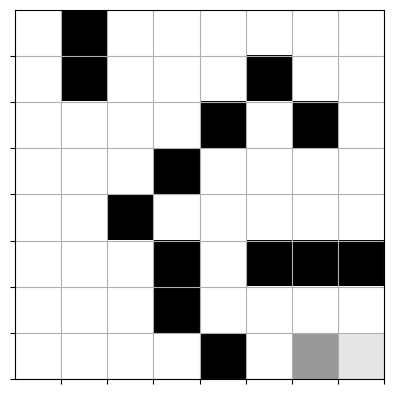

In [99]:
completion_check(model, qmaze)
show(qmaze)

The next cell simulates a full game based on what our model has learned and shows us the final path that our agent has taken.

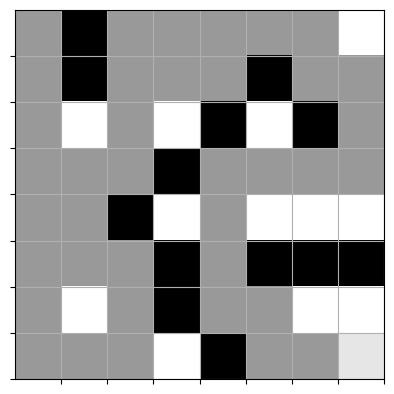

In [100]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)